# Regression Kriging: Comparing Covariates

This document includes Python codes that compare regression kriging with 1) bathymatry, 2) LDI, 3) basymatry+ LDI.

All date are shared in the [box folder](https://usf.box.com/s/xu3dw4i1emv2hzveyf9idnx9q78t939c).

# Table of Contents:

* [1.Load Data](#load_data)
* [2. Preprocess](#preprocess)
* [3. Combine Data](#read_data)
* [4. Spatial Interpolation of Dissolved Oxygen](#do_interpolate)
    * [4.1 Kriging:Dissolved Oxygen](#do_kriging)
    * [4.2 IDW:Dissolved Oxygen](#do_idw)
    * [4.3 Empirical Bayesian Kriging:Dissolved Oxygen](#do_ebk)
    * [4.4 Regression Kriging:Dissolved Oxygen](#do_rk)
* [5. Interpolation Validation of Dissolved Oxygen](#do_validation)
    * [5.1 Validation of Kriging:Dissolved Oxygen](#do_val_kriging)
    * [5.2 Validation of IDW:Dissolved Oxygen](#do_val_idw)
    * [5.3 Validation of Empirical Bayesian Kriging:Dissolved Oxygen](#do_val_ebk)
    * [5.4 Validation of Regression Kriging:Dissolved Oxygen](#do_val_rk)
    * [5.5 Validation Summary:Dissolved Oxygen](#do_val_sum) 
* [6. Spatial Interpolation of Salinity](#s_interpolate)
    * [6.1 Kriging:Dissolved Oxygen](#s_kriging)
    * [6.2 IDW:Dissolved Oxygen](#s_idw)
    * [6.3 Empirical Bayesian Kriging:Dissolved Oxygen](#s_ebk)
    * [6.4 Regression Kriging:Dissolved Oxygen](#s_rk)
* [7. Interpolation Validation of Salinity](#s_validation)
    * [7.1 Vlidation of Ordinary Kriging:Dissolved Oxygen](#s_val_kriging)
    * [7.2 Validation of IDW:Dissolved Oxygen](#s_val_idw)
    * [7.3 Validation of Empirical Bayesian Kriging:Dissolved Oxygen](#s_val_ebk)
    * [7.4 Validation of Regression Kriging:Dissolved Oxygen](#s_val_rk)
    * [7.5 Summary of Validation:Dissolved Oxygen](#s_val_sum)
* [8. Spatial Interpolation of Total Nitrogen](#tn_interpolate)
    * [8.1 Kriging:Total Nitrogen](#tn_kriging)
    * [8.2 IDW:Total Nitrogen](#tn_idw)
    * [8.3 Empirical Bayesian Kriging:Total Nitrogen](#tn_ebk)
    * [8.4 Regression Kriging:Total Nitrogen](#tn_rk)
* [9. Interpolation Validation of Total Nitrogen](#tn_validation)
    * [9.1 Vlidation of Kriging:Total Nitrogen](#tn_val_kriging)
    * [9.2 Validation of IDW:Total Nitrogen](#tn_val_idw)
    * [9.3 Validation of Empirical Bayesian Kriging:Total Nitrogen](#tn_val_ebk)
    * [9.4 Validation of Regression Kriging:Total Nitrogen](#tn_val_sum)
* [10 Summary of Validation](#val_sum)

In [1]:
import time
import math  
import sklearn.metrics  
import arcgisscripting
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rasterio as rio
import rasterio.mask
import rasterio.plot as rio_pl
import matplotlib.image as mpimg
import os
#import rioxarray as rxr

from rasterio.plot import show
from rasterio.transform import Affine
from rasterio.mask import mask
from rasterio import MemoryFile
from rasterio.profiles import DefaultGTiffProfile
from scipy.spatial import Voronoi, voronoi_plot_2d
from scipy.stats import sem
from sklearn.metrics import mean_squared_error
from shapely.geometry import box, Polygon, Point
from shapely import wkt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
import contextily as cx
#from osgeo import gdal
#from pykrige.ok import OrdinaryKriging

# import arcpy and environmental settings
import arcpy
from arcpy.sa import *
import misc.preprocess
import misc.interpolation
arcpy.env.overwriteOutput = True

# 1. Load and Preprocess Data <a class="anchor" id="load_data"></a>

In [2]:
path = "E:/Projects/SEACAR_WQ_Pilot/"
gis_path = path+'GIS_data/'

# path = "D:/Water_Quailty/"
# gis_path = path+'Test02200/'

Preprocess the data and save the preprocessed data in new files

In [3]:
# dfDis, dfCon = misc.preprocess.preprocess(path + r"OEAT_Discrete-2023-Jan-23.csv", 
#                     path + r"OEAT_Continuous_1-2023-Jan-23.csv",
#                     path + r"OEAT_Continuous_2-2023-Jan-23.csv")

# dfDis.to_csv(path + "discrete_0214.csv")
# dfCon.to_csv(path + "continuous_0214.csv")

To save time, we can load the preprocessed "discrete_0214.csv" and "continuous_0214.csv".

In [4]:
#dfDis = pd.read_csv("D:/Water_Quailty/Test0214/discrete_0214.csv")
#dfCon = pd.read_csv("D:/Water_Quailty/Test0214/continuous_0214.csv")

dfDis = pd.read_csv(path + "discrete_0214.csv")
dfCon = pd.read_csv(path + "continuous_0214.csv")

C:\Users\qiangy\AppData\Local\ESRI\conda\envs\geo3\lib\site-packages\IPython\core\interactiveshell.py:3442: DtypeWarning: Columns (11) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [5]:
col_ls = ['RowID','ParameterName','ParameterUnits','ProgramLocationID','ActivityType','ManagedAreaName',
                   'SampleDate','Year','Month','ResultValue','ValueQualifier','Latitude_DD','Longitude_DD']
para_ls = ["Salinity","Total Nitrogen","Dissolved Oxygen","Turbidity","Secchi Depth"]
para_ls_ab = ["S","TN","DO","T","SD"]
# Convert full MA names to short names
dictArea    = {'Gasparilla Sound-Charlotte Harbor Aquatic Preserve':'Charlotte Harbor','Big Bend Seagrasses Aquatic Preserve':'Big Bend',
                'Guana Tolomato Matanzas National Estuarine Research Reserve':'GTM Reserve','Estero Bay Aquatic Preserve':'Estero Bay',
                'Biscayne Bay Aquatic Preserve':'Biscayne Bay','Matlacha Pass Aquatic Preserve':'Matlacha Pass AP',
                'Lemon Bay Aquatic Preserve':'Lemon Bay','Cape Haze Aquatic Preserve':'Cape Haze','Pine Island Sound Aquatic Preserve':'Pine Island'}

# Convert full MA names to MA name in ORCP_Managed_Areas_Oct2021
dictArea2    = {'Gasparilla Sound-Charlotte Harbor Aquatic Preserve':'Gasparilla Sound-Charlotte Harbor','Big Bend Seagrasses Aquatic Preserve':'Big Bend Seagrasses',
                'Guana Tolomato Matanzas National Estuarine Research Reserve':'Guana Tolomato Matanzas NERR','Estero Bay Aquatic Preserve':'Estero Bay',
                'Biscayne Bay Aquatic Preserve':'Biscayne Bay','Matlacha Pass Aquatic Preserve':'Matlacha Pass',
                'Lemon Bay Aquatic Preserve':'Lemon Bay','Cape Haze Aquatic Preserve':'Cape Haze','Pine Island Sound Aquatic Preserve':'Pine Island Sound'}

dictUnits   = {"Salinity":"ppt","Total Nitrogen": "mg/L","Dissolved Oxygen": "mg/L","Turbidity": "NTU", "Secchi Depth": "m"}
listArea    = dfCon["ManagedAreaName"].unique()
listPara    = ["Salinity","Total Nitrogen","Dissolved Oxygen","Turbidity","Secchi Depth"] 
drySeason   = [11,12,1,2,3,4]
wetSeason = [5,6,7,8,9,10]


Area = 'Gasparilla Sound-Charlotte Harbor Aquatic Preserve'
Para = 'Dissolved Oxygen'
SpatialRef = '3086'
# dry_start,dry_end = '11/01/2016','04/30/2017'
# wet_start,wet_end = '05/01/2017','10/31/2017'

# 2. Combine Discrete and Continuous Data <a class="anchor" id="combine"></a>

Combine dis and con dataframes

In [6]:
# Set variables of the program
year = "2017"
Area = 'Gasparilla Sound-Charlotte Harbor Aquatic Preserve'
Para = 'Dissolved Oxygen'
Para_ab = "DO"
SpatialRef = '3086'

# ---------------------------- Uncomment in the first run --------------------------
dfDryMean, gdfDryAll = misc.preprocess.combine_dis_con_dry(dfDis,dfCon,year)
dfWetMean, gdfWetAll = misc.preprocess.combine_dis_con_wet(dfDis,dfCon,year)

gdfDryAll.to_csv(gis_path+'gdfDryAll{}.csv'.format(year))
gdfWetAll.to_csv(gis_path+'gdfWetAll{}.csv'.format(year))

gdfDrySelect = gdfDryAll[(gdfDryAll["ParameterName"]==Para)&(gdfDryAll["ManagedAreaName"]==Area)]
gdfWetSelect = gdfWetAll[(gdfWetAll["ParameterName"]==Para)&(gdfWetAll["ManagedAreaName"]==Area)]

gdfDrySelect.to_crs(int(SpatialRef)).to_file(gis_path+"Dry"+year+Para_ab+'.shp', driver='ESRI Shapefile',crs="EPSG:"+SpatialRef)
gdfWetSelect.to_crs(int(SpatialRef)).to_file(gis_path+"Wet"+year+Para_ab+'.shp', driver='ESRI Shapefile',crs="EPSG:"+SpatialRef)

C:\Users\qiangy\AppData\Local\Temp\ipykernel_46992\3146479256.py:18: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdfDrySelect.to_crs(int(SpatialRef)).to_file(gis_path+"Dry"+year+Para_ab+'.shp', driver='ESRI Shapefile',crs="EPSG:"+SpatialRef)
C:\Users\qiangy\AppData\Local\Temp\ipykernel_46992\3146479256.py:19: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdfWetSelect.to_crs(int(SpatialRef)).to_file(gis_path+"Wet"+year+Para_ab+'.shp', driver='ESRI Shapefile',crs="EPSG:"+SpatialRef)


Skip the preprocessing and load the pre-stored dataframes

In [7]:
# gdfDryAll = pd.read_csv(gis_path+'gdfDryAll{}.csv'.format(year))
# gdfDryAll = gdfDryAll['geometry'].apply(wkt.loads)
# gdfDryAll = gpd.GeoDataFrame(gdfDryAll, crs='epsg:'+SpatialRef)

# gdfWetAll = pd.read_csv(gis_path+'gdfWetAll{}.csv'.format(year))
# gdfWetAll = gdfWetAll['geometry'].apply(wkt.loads)
# gdfWetAll = gpd.GeoDataFrame(gdfWetAll, crs='epsg:'+SpatialRef)

# 3. Charlotte Harbor <a class="anchor" id="charlotte_harbor"></a>
## 3.1 Load Data

In [8]:
#MA = gpd.read_file(r"D:\Water_Quailty\ManagedAreas\ORCP_Managed_Areas_Oct2021.shp")
b_name = 'ch'
MA = gpd.read_file(gis_path + r"ORCP_Managed_Areas_Oct2021.shp")
CH = MA[MA['MA_Name']==dictArea2[Area]].to_crs(int(SpatialRef))
CH.to_file(gis_path+ '{}.shp'.format(b_name), driver='ESRI Shapefile',crs="EPSG:"+SpatialRef)

Also convert all shapefile to Florida GDL Albers (https://epsg.io/3086)

In [9]:
gdfDryShp = gpd.read_file(gis_path+"Dry"+year+Para_ab+'.shp')
gdfWetShp = gpd.read_file(gis_path+"Wet"+year+Para_ab+'.shp')
extentShp = gpd.read_file(gis_path+ '{}.shp'.format(b_name))

Text(0.5, 1.0, 'Sampling points at Gasparilla Sound-Charlotte Harbor Aquatic Preserve')

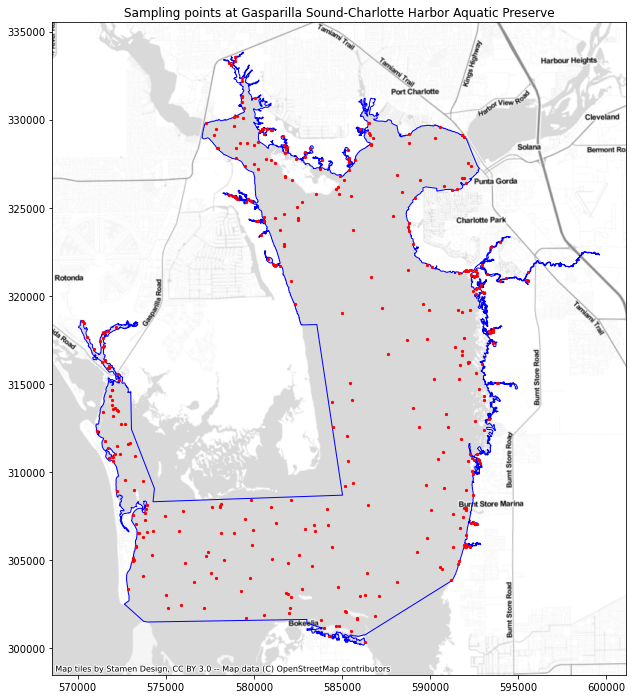

In [10]:
fig, ax = plt.subplots(figsize = (16,12))
extentShp.plot(ax = ax, color='none', edgecolor='blue')
gdfWetShp.plot(ax = ax, marker='o', color='red', markersize=5)
cx.add_basemap(ax = ax,source=cx.providers.Stamen.TonerLite,crs=gdfDryShp.crs)
ax.set_title('Sampling points at {}'.format(Area))

In [11]:
extent = str(extentShp.geometry.total_bounds).replace('[','').replace(']','')

## 4.2 Dissolved Oxygen <a class="anchor" id="do"></a>

### 4.2.1 Regression Kriging (covariate: LDI) <a class="anchor" id="do_rk_ldi"></a>

Run Oridinary Kriging for dry season data

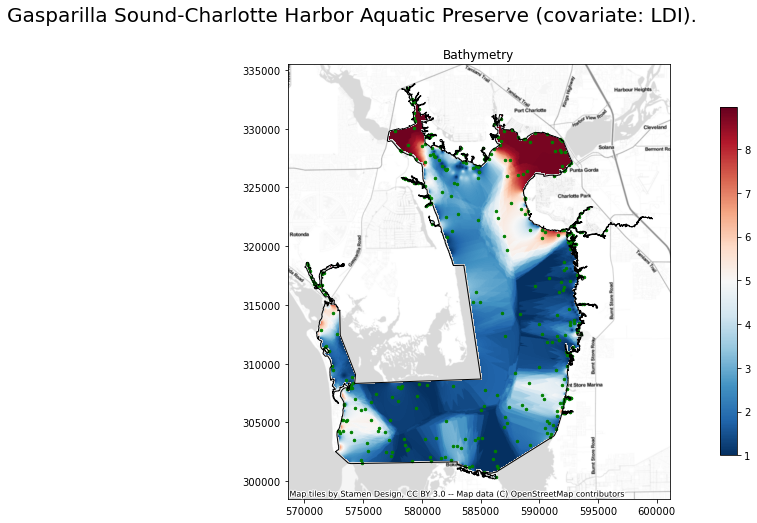

In [35]:
ma_table = pd.read_csv(gis_path + "MA_table.csv")
ra_fname = gis_path + "covariates/LDI/{}.tif".format(dictArea[Area])
#ra_fname = '{}.tif'.format(ma_table[ma_table['LONG_NAME']== Area]['MA_Name'].iloc[0].astype(str))
fig, ax = plt.subplots(1, figsize=(18, 8))

fig.suptitle("{} (covariate: {}).".format(Area, 'LDI'),fontsize=20)

gdfDryShp.plot(ax = ax, marker = 'o', color = 'green', markersize = 6)
extentShp.plot(ax = ax, color='none', edgecolor='black')
cx.add_basemap(ax = ax,source=cx.providers.Stamen.TonerLite,crs=gdfDryShp.crs)

#       Raster must added after basemap
with rasterio.open(ra_fname, "r+") as covar:
    band = covar.read(1)
    #band = numpy.ma.masked_array(band, mask=(band < -1000))
    #band = numpy.ma.masked_array(band, mask=(band > 1000))
    band = np.ma.masked_where((band < -100) | (band > 100), band)
    retted = rio_pl.show(band, transform=covar.transform, ax = ax, cmap="RdBu_r")
    ax.set_title('Bathymetry')
    # Add legend
    im = retted.get_images()[1]
    fig.colorbar(im, ax=ax,shrink=0.8)

In [46]:
year, season, method, value_field, mask, covariate = '2017', 'Dry','rk','ResultValu', gis_path+ '{}.shp'.format(b_name),'ldi'
in_explanatory_rasters = gis_path + "covariates/{}/{}.tif".format(covariate, dictArea[Area])

in_features = gis_path + season + year+Para_ab+'.shp'
out_ga_layer = gis_path +"{}{}{}_{}.lyrx".format(Para_ab, season.lower(), method.upper(),covariate[0:5])
out_raster = gis_path +"{}{}{}_{}.tif".format(Para_ab, season.lower(),method.upper(),covariate[0:5])

dryRK_2017 = misc.interpolation.interpolation(method = method, input_point = in_features, out_raster = out_raster, 
                                              z_field = value_field, out_ga_layer = out_ga_layer, extent = extent, 
                                              mask = mask, in_explanatory_rasters = in_explanatory_rasters)

season = 'Wet'
in_features = gis_path + season + year+Para_ab+'.shp'
out_ga_layer = gis_path +"{}{}{}_{}.lyrx".format(Para_ab, season.lower(), method.upper(),covariate[0:5])
out_raster = gis_path +"{}{}{}_{}.tif".format(Para_ab, season.lower(),method.upper(),covariate[0:5])

wetRK_2017 = misc.interpolation.interpolation(method = method, input_point = in_features, out_raster = out_raster, 
                                              z_field = value_field, out_ga_layer = out_ga_layer, extent = extent, 
                                              mask = mask, in_explanatory_rasters = in_explanatory_rasters)

Interpolation using the Regression Kriging method
--- Time lapse: 552.3064455986023 seconds ---
Interpolation using the Regression Kriging method
--- Time lapse: 555.1565697193146 seconds ---


Plot the interpolation result

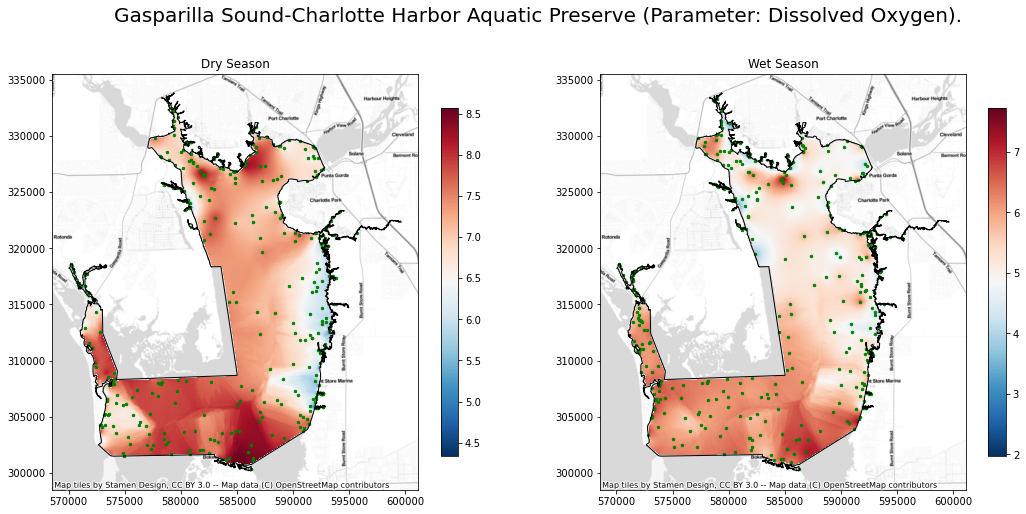

In [47]:
fig, axes = plt.subplots(1,2, figsize=(18, 8))

fig.suptitle("{} (Parameter: {}).".format(Area, Para),fontsize=20)

misc.interpolation.plot_raster(gdfDryShp, extentShp, dryRK_2017, 'Dry Season', axes[0], fig)
misc.interpolation.plot_raster(gdfWetShp, extentShp, wetRK_2017, 'Wet Season', axes[1], fig)

### 4.2.2 Regression Kriging (covariate: bathymetry) <a class="anchor" id="do_rk_bathy"></a>


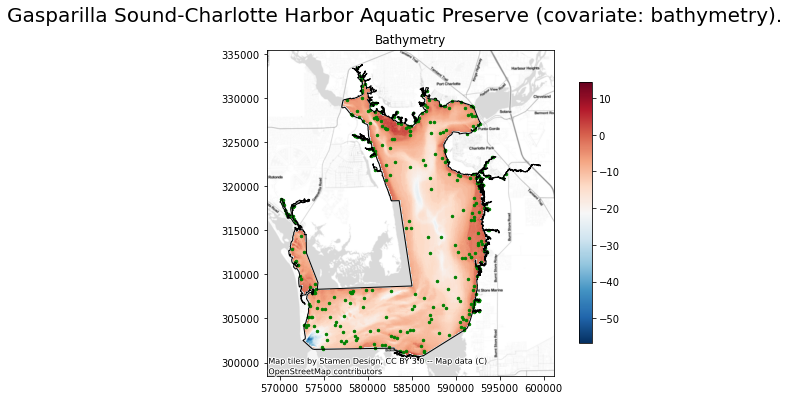

In [48]:
ma_table = pd.read_csv(gis_path + "MA_table.csv")
ra_fname = gis_path + "covariates/bathymetry/{}.tif".format(dictArea[Area])

fig, ax = plt.subplots(1, figsize=(9, 6))

fig.suptitle("{} (covariate: {}).".format(Area, 'bathymetry'),fontsize=20)

gdfDryShp.plot(ax = ax, marker = 'o', color = 'green', markersize = 6)
extentShp.plot(ax = ax, color='none', edgecolor='black')
cx.add_basemap(ax = ax,source=cx.providers.Stamen.TonerLite,crs=gdfDryShp.crs)

#       Raster must added after basemap
with rasterio.open(ra_fname, "r+") as covar:
    band = covar.read(1)
    #band = numpy.ma.masked_array(band, mask=(band < -1000))
    #band = numpy.ma.masked_array(band, mask=(band > 1000))
    band = np.ma.masked_where((band < -100) | (band > 100), band)
    retted = rio_pl.show(band, transform=covar.transform, ax = ax, cmap="RdBu_r")
    ax.set_title('Bathymetry')
    # Add legend
    im = retted.get_images()[1]
    fig.colorbar(im, ax=ax,shrink=0.8)

RK interpolation

In [49]:
year, season, method, value_field, mask, covariate = '2017', 'Dry','rk','ResultValu', gis_path+ '{}.shp'.format(b_name),'bathymetry'
in_explanatory_rasters = gis_path + "covariates/{}/{}.tif".format(covariate, dictArea[Area])

in_features = gis_path + season + year + Para_ab + '.shp'
out_ga_layer = gis_path +"{}{}{}_{}.lyrx".format(Para_ab, season.lower(), method.upper(),covariate[0:5])
out_raster = gis_path +"{}{}{}_{}.tif".format(Para_ab, season.lower(),method.upper(),covariate[0:5])

dryRK_2017 = misc.interpolation.interpolation(method = method, input_point = in_features, out_raster = out_raster, 
                                              z_field = value_field, out_ga_layer = out_ga_layer, extent = extent, 
                                              mask = mask, in_explanatory_rasters = in_explanatory_rasters)

season = 'Wet'
in_features = gis_path + season + year + Para_ab + '.shp'
out_ga_layer = gis_path +"{}{}{}_{}.lyrx".format(Para_ab, season.lower(), method.upper(),covariate[0:5])
out_raster = gis_path +"{}{}{}_{}.tif".format(Para_ab, season.lower(),method.upper(),covariate[0:5])

wetRK_2017 = misc.interpolation.interpolation(method = method, input_point = in_features, out_raster = out_raster, 
                                              z_field = value_field, out_ga_layer = out_ga_layer, extent = extent, 
                                              mask = mask, in_explanatory_rasters = in_explanatory_rasters)

Interpolation using the Regression Kriging method
--- Time lapse: 562.6945209503174 seconds ---
Interpolation using the Regression Kriging method
--- Time lapse: 435.49033665657043 seconds ---


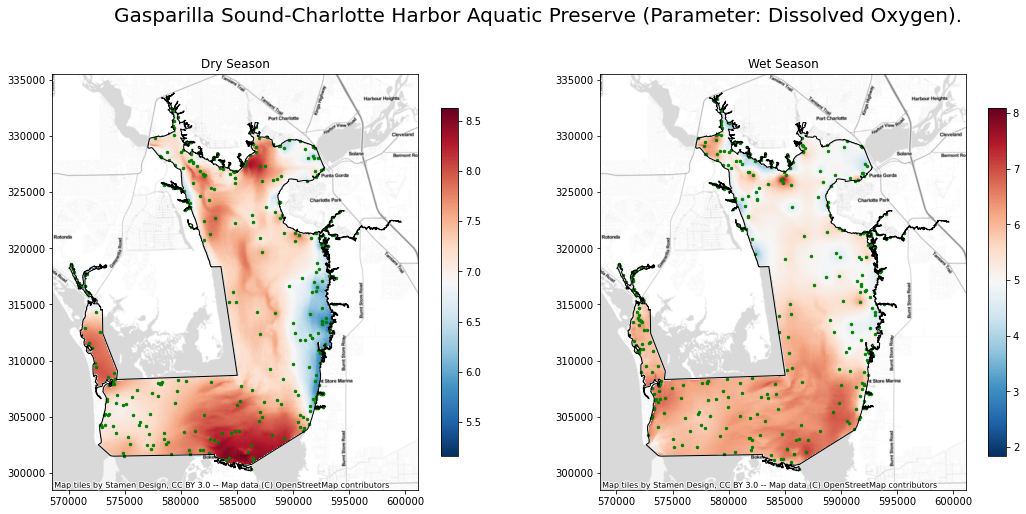

In [51]:
fig, axes = plt.subplots(1,2, figsize=(18, 8))

fig.suptitle("{} (Parameter: {}).".format(Area, Para),fontsize=20)

misc.interpolation.plot_raster(gdfDryShp, extentShp, dryRK_2017, 'Dry Season', axes[0],fig)
misc.interpolation.plot_raster(gdfWetShp, extentShp, wetRK_2017, 'Wet Season', axes[1],fig)


### 4.2.3 Regression Kriging (covariate: bathymetry + LDI) <a class="anchor" id="do_rk_ldi_bathy"></a>


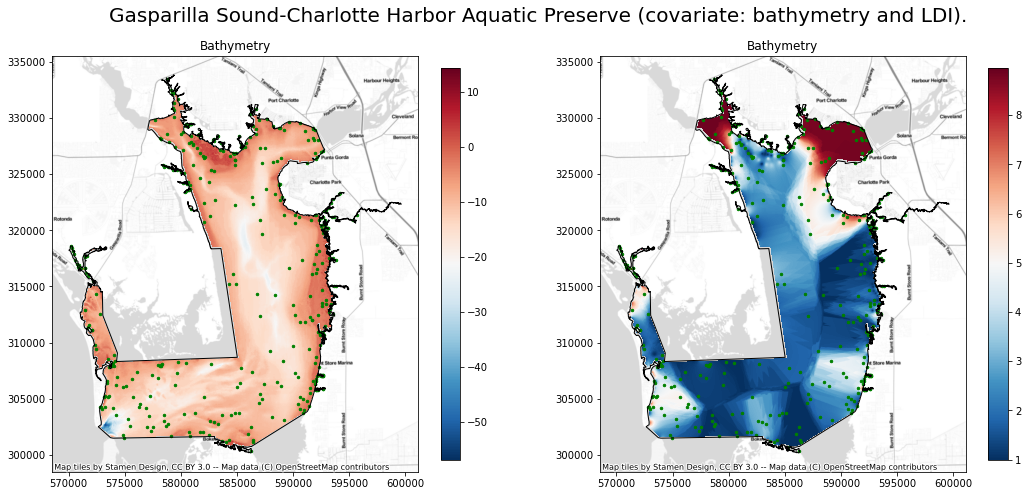

In [12]:
ma_table = pd.read_csv(gis_path + "MA_table.csv")

fig, ax = plt.subplots(1,2, figsize=(18, 12))
fig.suptitle("{} (covariate: {}).".format(Area, 'bathymetry and LDI'),fontsize=20,y=0.8) 

ra_fname = gis_path + "covariates/bathymetry/{}.tif".format(dictArea[Area])
misc.interpolation.plot_covariate(Area,gdfDryShp,extentShp,ra_fname,ax[0], fig)

ra_fname = gis_path + "covariates/ldi/{}.tif".format(dictArea[Area])
misc.interpolation.plot_covariate(Area,gdfDryShp,extentShp,ra_fname,ax[1], fig)


In [18]:
year, season, method, value_field, mask, covariate = '2017', 'Dry','rk','ResultValu', gis_path+ '{}.shp'.format(b_name), 'b_ldi'
in_explanatory_rasters = [gis_path + "covariates/bathymetry/{}.tif".format(dictArea[Area]),
                          gis_path + "covariates/ldi/{}.tif".format(dictArea[Area])]

in_features = gis_path + season + year+Para_ab+'.shp'
out_ga_layer = gis_path +"{}{}{}_{}.lyrx".format(Para_ab, season.lower(), method.upper(),covariate[0:5])
out_raster = gis_path +"{}{}{}_{}.tif".format(Para_ab, season.lower(),method.upper(),covariate[0:5])

dryRK_2017 = misc.interpolation.interpolation(method = method, input_point = in_features, out_raster = out_raster, 
                                              z_field = value_field, out_ga_layer = out_ga_layer, extent = extent, 
                                              mask = mask, in_explanatory_rasters = in_explanatory_rasters)

season = 'Wet'
in_features = gis_path + season + year+Para_ab+'.shp'
out_ga_layer = gis_path +"{}{}{}_{}.lyrx".format(Para_ab, season.lower(), method.upper(),covariate[0:5])
out_raster = gis_path +"{}{}{}_{}.tif".format(Para_ab, season.lower(),method.upper(),covariate[0:5])

wetRK_2017 = misc.interpolation.interpolation(method = method, input_point = in_features, out_raster = out_raster, 
                                              z_field = 'ResultValu', out_ga_layer = out_ga_layer, extent = extent, 
                                              mask = mask, in_explanatory_rasters = in_explanatory_rasters)

Interpolation using the Regression Kriging method
--- Time lapse: 670.2606573104858 seconds ---
Interpolation using the Regression Kriging method
--- Time lapse: 678.4976172447205 seconds ---


Plot interpolation results

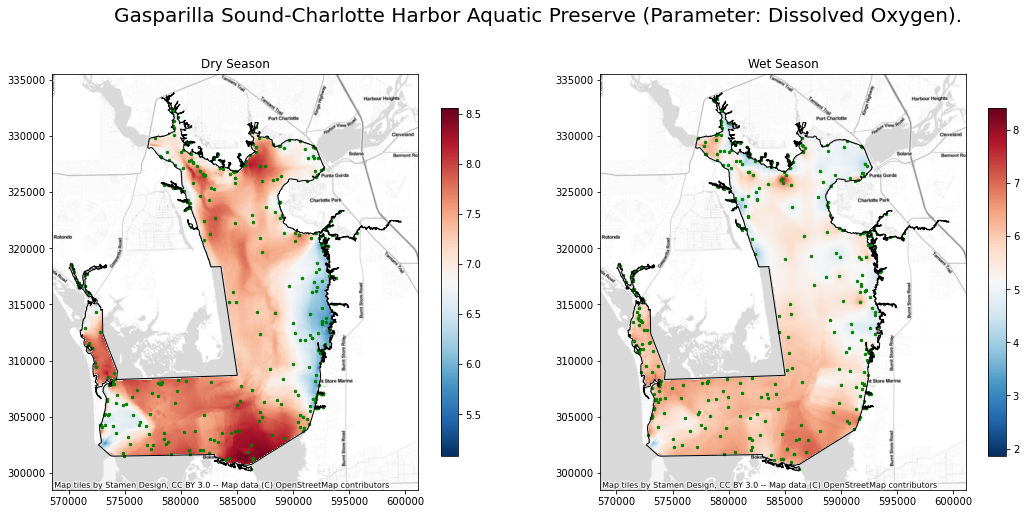

In [19]:
fig, axes = plt.subplots(1,2, figsize=(18, 8))

fig.suptitle("{} (Parameter: {}).".format(Area, Para),fontsize=20)

misc.interpolation.plot_raster(gdfDryShp, extentShp, dryRK_2017, 'Dry Season', axes[0],fig)
misc.interpolation.plot_raster(gdfWetShp, extentShp, wetRK_2017, 'Wet Season', axes[1],fig)


## 4.2.4 Interpolation Validation <a class="anchor" id="do_rk_val"></a>

Validate RK with Bathymetry & LDI

In [20]:
method, season, covariate = 'rk', 'dry', 'b_ldi'
inLayer = gis_path +"{}{}{}_{}.lyrx".format(Para_ab, season.lower(), method.upper(),covariate[0:5])

cvResult = arcpy.CrossValidation_ga(inLayer)
dryRKStat3 = pd.DataFrame(
            {
              "meanError": round(float(cvResult.meanError),4),
              "meanStandardizedError": round(float(cvResult.meanStandardized),4),
              "rootMeanSquareError": round(float(cvResult.rootMeanSquare),4)
                                          },index=["Regression Kriging"])


season = 'wet'
inLayer = gis_path +"{}{}{}.lyrx".format(Para_ab, season.lower(), method.upper())

cvResult = arcpy.CrossValidation_ga(inLayer)
wetRKStat3 = pd.DataFrame(
            {
              "meanError": round(float(cvResult.meanError),4),
              "meanStandardizedError": round(float(cvResult.meanStandardized),4),
              "rootMeanSquareError": round(float(cvResult.rootMeanSquare),4)
                                          },index=["Regression Kriging"])

## 5.2 Validation: Inverse Distance Weighting (IDW) <a class="anchor" id="do_val_idw"></a>

In [33]:
arcpy.SaveToLayerFile_management(gis_path+Para_ab + "dryIDW.lyrx", gis_path+Para_ab+'dryIDW_GA.lyrx',
                                 'ABSOLUTE')
arcpy.SaveToLayerFile_management(gis_path+Para_ab + "wetIDW.lyrx", gis_path+Para_ab+'wetIDW_GA.lyrx',
                                 'ABSOLUTE')

<Result 'D:\\Water_Quailty\\Test0220\\wetIDW_GA.lyrx'>

In [34]:
#inLayer = gis_path+Para_ab + "dryIDW_GA.lyrx"
method, season = 'idw', 'dry'
inLayer = gis_path +"{}{}{}.lyrx".format(Para_ab, season.lower(), method.upper())
cvResult = arcpy.CrossValidation_ga(inLayer)
dryIDWStat = pd.DataFrame(
            {
              "meanError": round(float(cvResult.meanError),4),
#               "meanStandardizedError": round(float(cvResult.meanStandardized),4),
              "meanStandardizedError": "Nan",
              "rootMeanSquareError": round(float(cvResult.rootMeanSquare),4)
                                          },index=["Inverse Distance Weighting"])


method, season = 'idw', 'wet'
inLayer = gis_path +"{}{}{}.lyrx".format(Para_ab, season.lower(), method.upper())
cvResult = arcpy.CrossValidation_ga(inLayer)
wetIDWStat = pd.DataFrame(
            {
              "meanError": round(float(cvResult.meanError),4),
#               "meanStandardizedError": round(float(cvResult.meanStandardized),4),
              "meanStandardizedError": "Nan",
              "rootMeanSquareError": round(float(cvResult.rootMeanSquare),4)
                                          },index=["Inverse Distance Weighting"])

In [36]:
print("Interpolation assessment of Inverse Distance Weighting in dry season data")
display(dryIDWStat)
print("Interpolation assessment of Inverse Distance Weighting in wet season data")
display(wetIDWStat)

Interpolation assessment of Inverse Distance Weighting in dry season data


meanError meanStandardizedError  \
Inverse Distance Weighting     -0.069                   Nan   

                            rootMeanSquareError  
Inverse Distance Weighting                1.775

Interpolation assessment of Inverse Distance Weighting in wet season data


meanError meanStandardizedError  \
Inverse Distance Weighting     -0.049                   Nan   

                            rootMeanSquareError  
Inverse Distance Weighting               1.9753

## 5.3 Validation: Empirical Bayesian Kriging <a class="anchor" id="do_val_ebk"></a>

In [37]:
arcpy.SaveToLayerFile_management(gis_path+Para_ab+"EBK_Dry_Layer", gis_path+Para_ab+'dryEBK_GA.lyrx',
                                 'ABSOLUTE')
arcpy.SaveToLayerFile_management(gis_path+Para_ab+"EBK_Wet_Layer", gis_path+Para_ab+'wetEBK_GA.lyrx',
                                 'ABSOLUTE')

<Result 'D:\\Water_Quailty\\Test0220\\wetEBK_GA.lyrx'>

In [38]:
inLayer = gis_path+Para_ab + "dryEBK_GA.lyrx"
cvResult = arcpy.CrossValidation_ga(inLayer)
dryEBKStat = pd.DataFrame(
            {
              "meanError": round(float(cvResult.meanError),4),
              "meanStandardizedError": round(float(cvResult.meanStandardized),4),
              "rootMeanSquareError": round(float(cvResult.rootMeanSquare),4)
                                          },index=["Empirical Bayesian Kriging"])


inLayer = gis_path+Para_ab + "wetEBK_GA.lyrx"
cvResult = arcpy.CrossValidation_ga(inLayer)
wetEBKStat = pd.DataFrame(
            {
              "meanError": round(float(cvResult.meanError),4),
              "meanStandardizedError": round(float(cvResult.meanStandardized),4),
              "rootMeanSquareError": round(float(cvResult.rootMeanSquare),4)
                                          },index=["Empirical Bayesian Kriging"])

In [39]:
print("Interpolation assessment of Empirical Bayesian Kriging in dry season data")
display(dryEBKStat)
print("Interpolation assessment of Empirical Bayesian Kriging in wet season data")
display(wetEBKStat)

Interpolation assessment of Empirical Bayesian Kriging in dry season data


meanError  meanStandardizedError  \
Empirical Bayesian Kriging    -0.0076                -0.0013   

                            rootMeanSquareError  
Empirical Bayesian Kriging               1.5951

Interpolation assessment of Empirical Bayesian Kriging in wet season data


meanError  meanStandardizedError  \
Empirical Bayesian Kriging    -0.0079                -0.0036   

                            rootMeanSquareError  
Empirical Bayesian Kriging               1.7716

## 5.4 Validation: Regression Kriging <a class="anchor" id="do_val_rk"></a>

In [40]:
arcpy.SaveToLayerFile_management(gis_path+Para_ab+"dryRK_GA", gis_path+Para_ab+'dryRK_GA.lyrx',
                                 'ABSOLUTE')
arcpy.SaveToLayerFile_management(gis_path+Para_ab+"wetRK_GA", gis_path+Para_ab+'wetRK_GA.lyrx',
                                 'ABSOLUTE')

<Result 'D:\\Water_Quailty\\Test0220\\wetRK_GA.lyrx'>

In [41]:
inLayer = gis_path+Para_ab + "dryRK_GA.lyrx"
cvResult = arcpy.CrossValidation_ga(inLayer)
dryRKStat = pd.DataFrame(
            {
              "meanError": round(float(cvResult.meanError),4),
              "meanStandardizedError": round(float(cvResult.meanStandardized),4),
              "rootMeanSquareError": round(float(cvResult.rootMeanSquare),4)
                                          },index=["Regression Kriging"])


inLayer = gis_path+Para_ab + "wetRK_GA.lyrx"
cvResult = arcpy.CrossValidation_ga(inLayer)
wetRKStat = pd.DataFrame(
            {
              "meanError": round(float(cvResult.meanError),4),
              "meanStandardizedError": round(float(cvResult.meanStandardized),4),
              "rootMeanSquareError": round(float(cvResult.rootMeanSquare),4)
                                          },index=["Regression Kriging"])

In [42]:
print("Interpolation assessment of Regression Kriging in dry season data")
display(dryRKStat)
print("Interpolation assessment of Regression Kriging in wet season data")
display(wetRKStat)

Interpolation assessment of Regression Kriging in dry season data


meanError  meanStandardizedError  rootMeanSquareError
Regression Kriging     0.0189                 0.0129                1.599

Interpolation assessment of Regression Kriging in wet season data


meanError  meanStandardizedError  rootMeanSquareError
Regression Kriging     0.0466                 0.0254               1.7467

## 5.5 Summary of Validation (comparing four methods) <a class="anchor" id="do_val_sum"></a>

In [43]:
sumStat1   = pd.concat([dryOKStat,dryIDWStat])
sumStat2   = pd.concat([dryEBKStat,dryRKStat])
sumStatDry = pd.concat([sumStat1,sumStat2])

In [44]:
print("Summary of interpolation assessment in dry season data")
sumStatDry

Summary of interpolation assessment in dry season data


meanError meanStandardizedError  \
Ordinary Kriging               0.0559                0.0328   
Inverse Distance Weighting    -0.0690                   Nan   
Empirical Bayesian Kriging    -0.0076               -0.0013   
Regression Kriging             0.0189                0.0129   

                            rootMeanSquareError  
Ordinary Kriging                         1.6362  
Inverse Distance Weighting               1.7750  
Empirical Bayesian Kriging               1.5951  
Regression Kriging                       1.5990

In [45]:
sumStat3   = pd.concat([wetOKStat,wetIDWStat])
sumStat4   = pd.concat([wetEBKStat,wetRKStat])
sumStatWet = pd.concat([sumStat3,sumStat4])

In [46]:
print("Summary of interpolation assessment in wet season data")
sumStatWet

Summary of interpolation assessment in wet season data


meanError meanStandardizedError  \
Ordinary Kriging               0.0121                0.0083   
Inverse Distance Weighting    -0.0490                   Nan   
Empirical Bayesian Kriging    -0.0079               -0.0036   
Regression Kriging             0.0466                0.0254   

                            rootMeanSquareError  
Ordinary Kriging                         1.8292  
Inverse Distance Weighting               1.9753  
Empirical Bayesian Kriging               1.7716  
Regression Kriging                       1.7467

# 6. Spatial Interpolation of Salinity <a class="anchor" id="s_interpolate"></a>

In [ ]:
# year = "2017"

# dfDis["timestamp"]=  pd.to_datetime(dfDis['SampleDate'])
# dfCon["timestamp"]=  pd.to_datetime(dfCon['SampleDate'])

# dfDryMean, gdfDryAll = combine_dis_con_dry(dfDis,dfCon,year)
# dfWetMean, gdfWetAll = combine_dis_con_wet(dfDis,dfCon,year)

Para = 'Salinity'
Para_ab = 'S'

gdfDrySelect = gdfDryAll[(gdfDryAll["ParameterName"]==Para)&(gdfDryAll["ManagedAreaName"]==Area)]
gdfWetSelect = gdfWetAll[(gdfWetAll["ParameterName"]==Para)&(gdfWetAll["ManagedAreaName"]==Area)]

gdfDrySelect.to_crs(int(SpatialRef)).to_file(gis_path+"Dry"+year+Para_ab+'.shp', driver='ESRI Shapefile',crs="EPSG:"+SpatialRef)
gdfWetSelect.to_crs(int(SpatialRef)).to_file(gis_path+"Wet"+year+Para_ab+'.shp', driver='ESRI Shapefile',crs="EPSG:"+SpatialRef)

In [80]:
gdfDryShp = gpd.read_file(gis_path+"Dry"+year+Para_ab+'.shp')
gdfWetShp = gpd.read_file(gis_path+"Wet"+year+Para_ab+'.shp')
extentShp = gpd.read_file(gis_path+"ch.shp")

<AxesSubplot:>

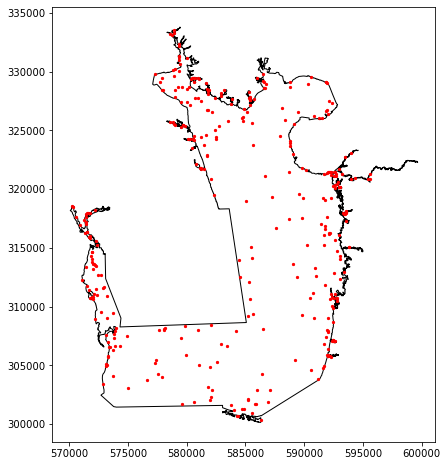

In [87]:
fig, ax = plt.subplots(figsize = (12,8))
extentShp.plot(ax = ax, color='white', edgecolor='black')
gdfWetShp.plot(ax = ax, marker='o', color='red', markersize=5)

## 6.1 Ordinary Kriging (Salinity) <a class="anchor" id="s_ok"></a>

In [107]:
year, season, method, value_field, mask = '2017', 'Dry','ok','ResultValu', gis_path+ '{}.shp'.format(b_name)
in_features = gis_path + season + year+Para_ab+'.shp'
out_ga_layer = gis_path +"{}{}{}.lyrx".format(Para_ab, season.lower(), method.upper())
out_raster = gis_path +"{}{}{}.tif".format(Para_ab, season.lower(),method.upper())

dryOK_2017, dryOKStat = misc.interpolation.interpolation(method = method, input_point = in_features, 
                      out_raster = out_raster, z_field = value_field, 
                      out_ga_layer = out_ga_layer, extent = extent, 
                      mask = mask)

season = 'Wet'
wetOK_2017,wetOKStat = misc.interpolation.interpolation(method = method, input_point = gis_path + season + year+Para_ab+'.shp', 
                      out_raster = gis_path +"{}{}{}.tif".format(Para_ab, season.lower(),method.upper()), z_field = 'ResultValu', 
                      out_ga_layer = gis_path +"{}{}{}.lyrx".format(Para_ab, season.lower(), method.upper()), extent = extent, 
                      mask = mask)

Interpolation using the Ordinary Kriging method
--- Time lapse: 11.948103189468384 seconds ---
Interpolation using the Ordinary Kriging method
--- Time lapse: 12.703660249710083 seconds ---


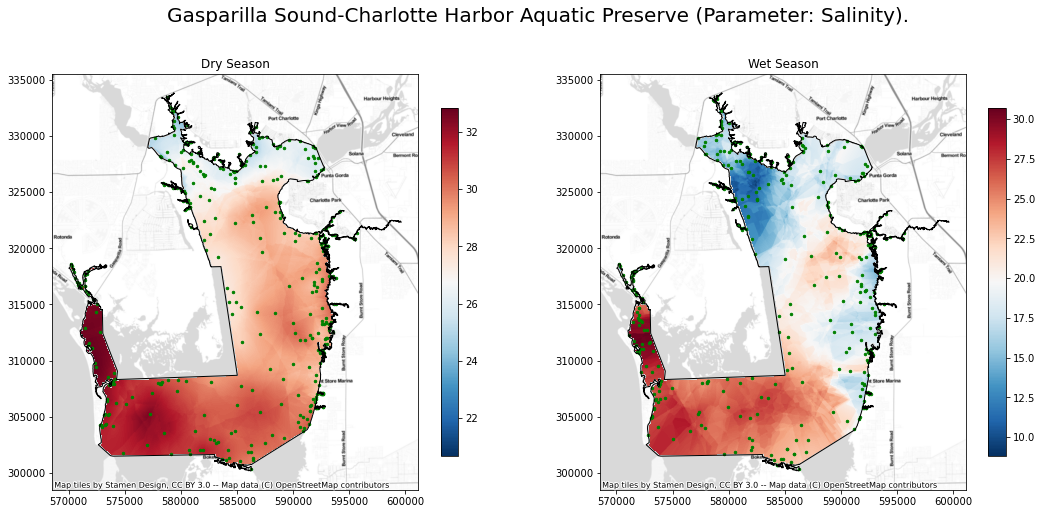

In [108]:
fig, axes = plt.subplots(1,2, figsize=(18, 8))

fig.suptitle("{} (Parameter: {}).".format(Area, Para),fontsize=20)

misc.interpolation.plot_raster(gdfDryShp, extentShp, dryOK_2017, 'Dry Season', axes[0], fig)
misc.interpolation.plot_raster(gdfWetShp, extentShp, wetOK_2017, 'Wet Season', axes[1], fig)

## 6.2 Inverse Distance Weighting (IDW): Salinity <a class="anchor" id="s_idw"></a>

Run IDW for both wet and dry seasons

In [109]:
year, season, method, value_field, mask = '2017', 'Dry','idw','ResultValu', gis_path+ '{}.shp'.format(b_name)
in_features = gis_path + season + year+Para_ab+'.shp'
out_ga_layer = gis_path +"{}{}{}.lyrx".format(Para_ab, season.lower(), method.upper())
out_raster = gis_path +"{}{}{}.tif".format(Para_ab, season.lower(),method.upper())

dryIDW_2017 = misc.interpolation.interpolation(method = method, input_point = in_features, 
                      out_raster = out_raster, z_field = value_field, 
                      out_ga_layer = out_ga_layer, extent = extent, 
                      mask = mask)

season = 'Wet'
wetIDW_2017 = misc.interpolation.interpolation(method = method, input_point = gis_path + season + year+Para_ab+'.shp', 
                      out_raster = gis_path +"{}{}{}.tif".format(Para_ab, season.lower(),method.upper()), z_field = 'ResultValu', 
                      out_ga_layer = gis_path +"{}{}{}.lyrx".format(Para_ab, season.lower(), method.upper()), extent = extent, 
                      mask = mask)


Interpolation using the Inverse Distance Weighting (IDW) method
--- Time lapse: 14.305318832397461 seconds ---
Interpolation using the Inverse Distance Weighting (IDW) method
--- Time lapse: 13.927391529083252 seconds ---


Plot the interpolation result

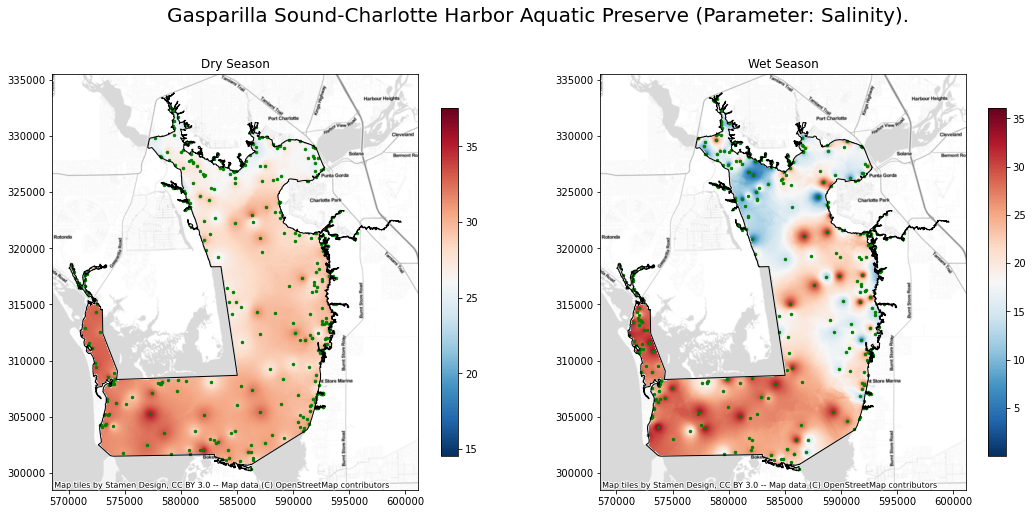

In [110]:
fig, axes = plt.subplots(1,2, figsize=(18, 8))

fig.suptitle("{} (Parameter: {}).".format(Area, Para),fontsize=20)

misc.interpolation.plot_raster(gdfDryShp, extentShp, dryIDW_2017, 'Dry Season', axes[0],fig)
misc.interpolation.plot_raster(gdfWetShp, extentShp, wetIDW_2017, 'Wet Season', axes[1],fig)

## 6.3 Empirical Bayesian Kriging (EBK): Salinity <a class="anchor" id="s_ebk"></a>

Run EBK for wet and dry seasons

In [105]:
year, season, method, value_field, mask = '2017', 'Dry','ebk','ResultValu', gis_path+ '{}.shp'.format(b_name)
in_features = gis_path + season + year+Para_ab+'.shp'
out_ga_layer = gis_path +"{}{}{}.lyrx".format(Para_ab, season.lower(), method.upper())
out_raster = gis_path +"{}{}{}.tif".format(Para_ab, season.lower(),method.upper())

dryEBK_2017 = misc.interpolation.interpolation(method = method, input_point = in_features, 
                      out_raster = out_raster, z_field = value_field, 
                      out_ga_layer = out_ga_layer, extent = extent, 
                      mask = mask)

season = 'Wet'
wetEBK_2017 = misc.interpolation.interpolation(method = method, input_point = gis_path + season + year+Para_ab+'.shp', 
                      out_raster = gis_path +"{}{}{}.tif".format(Para_ab, season.lower(),method.upper()), z_field = 'ResultValu', 
                      out_ga_layer = gis_path +"{}{}{}.lyrx".format(Para_ab, season.lower(), method.upper()), extent = extent, 
                      mask = mask)

Interpolation using the Empirical Bayesian Kriging method
--- Time lapse: 275.8697922229767 seconds ---
Interpolation using the Empirical Bayesian Kriging method
--- Time lapse: 275.8618459701538 seconds ---


Plot interpolation results

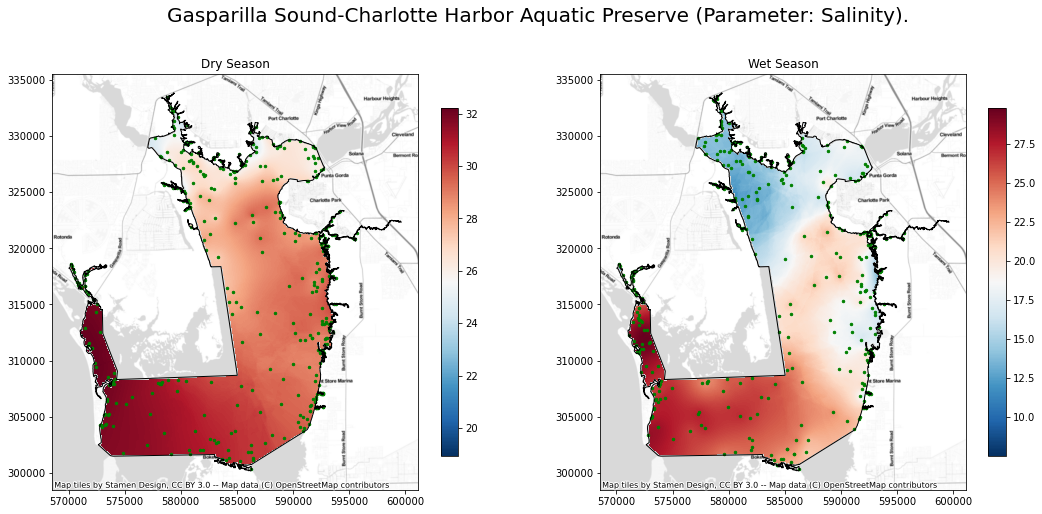

In [106]:
fig, axes = plt.subplots(1,2, figsize=(18, 8))

fig.suptitle("{} (Parameter: {}).".format(Area, Para),fontsize=20)

misc.interpolation.plot_raster(gdfDryShp, extentShp, dryEBK_2017, 'Dry Season', axes[0],fig)
misc.interpolation.plot_raster(gdfWetShp, extentShp, wetEBK_2017, 'Wet Season', axes[1],fig)

## 6.4 Regression Kriging (RK): Salinity <a class="anchor" id="s_rk"></a>

Display covariates

In [ ]:
ma_table = pd.read_csv(gis_path + "MA_table.csv")
ra_fname = 'basy_{}.tif'.format(ma_table[ma_table['LONG_NAME']== Area]['MA_AreaID'].iloc[0].astype(str))
fig, ax = plt.subplots(1, figsize=(18, 8))

fig.suptitle("{} (covariate: {}).".format(Area, 'basymetry'),fontsize=20)

gdfDryShp.plot(ax = ax, marker = 'o', color = 'green', markersize = 6)
extentShp.plot(ax = ax, color='none', edgecolor='black')
cx.add_basemap(ax = ax,source=cx.providers.Stamen.TonerLite,crs=gdfDryShp.crs)

#       Raster must added after basemap
with rasterio.open(gis_path + "covariates/basymetry/basy_18.tif", "r+") as covar:
    band = covar.read(1)
    #band = numpy.ma.masked_array(band, mask=(band < -1000))
    #band = numpy.ma.masked_array(band, mask=(band > 1000))
    band = np.ma.masked_where((band < -100) | (band > 100), band)
    retted = rio_pl.show(band, transform=covar.transform, ax = ax, cmap="RdBu_r")
    ax.set_title('Bathymetry')
    # Add legend
    im = retted.get_images()[1]
    fig.colorbar(im, ax=ax,shrink=0.8)


RK interpolation

In [ ]:

year, season, method, value_field, mask = '2017', 'Dry','rk','ResultValu', gis_path+ '{}.shp'.format(b_name)
in_features = gis_path + season + year+Para_ab+'.shp'
out_ga_layer = gis_path +"{}{}{}.lyrx".format(Para_ab, season.lower(), method.upper())
out_raster = gis_path +"{}{}{}.tif".format(Para_ab, season.lower(),method.upper())

dryRK_2017 = misc.interpolation.interpolation(method = method, input_point = in_features, 
                      out_raster = out_raster, z_field = value_field, 
                      out_ga_layer = out_ga_layer, extent = extent, 
                      mask = mask, in_explanatory_rasters = gis_path + "covariates/{}".format('NCEI_DEM_30m.tif'))

season = 'Wet'
wetRK_2017 = misc.interpolation.interpolation(method = method, input_point = gis_path + season + year+Para_ab+'.shp', 
                      out_raster = gis_path +"{}{}{}.tif".format(Para_ab, season.lower(),method.upper()), z_field = 'ResultValu', 
                      out_ga_layer = gis_path +"{}{}{}.lyrx".format(Para_ab, season.lower(), method.upper()), extent = extent, 
                      mask = mask, in_explanatory_rasters = gis_path + "covariates/{}".format('NCEI_DEM_30m.tif'))

Display result

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(18, 8))

fig.suptitle("{} (Parameter: {}).".format(Area, Para),fontsize=20)

misc.interpolation.plot_raster(gdfDryShp, extentShp, dryRK_2017, 'Dry Season', axes[0],fig)
misc.interpolation.plot_raster(gdfWetShp, extentShp, wetRK_2017, 'Wet Season', axes[1],fig)

# 7. Interpolation Validation: Salinity <a class="anchor" id="s_validation"></a>
## 7.1 Validation of Ordinary Kriging <a class="anchor" id="s_val_ok"></a>

In [35]:
gp = arcgisscripting.create()
gp.workspace = gis_path
gp.CheckOutExtension( 'GeoStats' )

ordinarykriging_xml = gis_path+'{}_Kriging.xml'.format(b_name)
geo_datasets = arcpy.GeostatisticalDatasets(ordinarykriging_xml)
geo_datasets.dataset1 = gis_path+"Dry"+year+Para_ab+'.shp'
geo_datasets.dataset1Field = 'ResultValu'
arcpy.GACreateGeostatisticalLayer_ga(ordinarykriging_xml, geo_datasets, Para_ab+'dryok_GA')
arcpy.SaveToLayerFile_management(Para_ab+'dryok_GA', gis_path+Para_ab+'dryok_GA.lyrx',
                                 'ABSOLUTE')

ordinarykriging_xml = gis_path+'{}_Kriging.xml'.format(b_name)
geo_datasets = arcpy.GeostatisticalDatasets(ordinarykriging_xml)
geo_datasets.dataset1 = gis_path+"Wet"+year+Para_ab+'.shp'
geo_datasets.dataset1Field = 'ResultValu'
arcpy.GACreateGeostatisticalLayer_ga(ordinarykriging_xml, geo_datasets, Para_ab+'wetok_GA')
arcpy.SaveToLayerFile_management(Para_ab+'wetok_GA', gis_path+Para_ab+'wetok_GA.lyrx',
                                 'ABSOLUTE')

TypeError: bad argument type for built-in operation

In [113]:
inLayer = gis_path +Para_ab+ "dryok_GA.lyrx"
cvResult = arcpy.CrossValidation_ga(inLayer)
dryOKStat = pd.DataFrame(
            {
              "meanError": round(float(cvResult.meanError),4),
              "meanStandardizedError": round(float(cvResult.meanStandardized),4),
              "rootMeanSquareError": round(float(cvResult.rootMeanSquare),4)
                                          },index=["Ordinary Kriging"])


inLayer = gis_path +Para_ab+ "wetok_GA.lyrx"
cvResult = arcpy.CrossValidation_ga(inLayer)
wetOKStat = pd.DataFrame(
            {
              "meanError": round(float(cvResult.meanError),4),
              "meanStandardizedError": round(float(cvResult.meanStandardized),4),
              "rootMeanSquareError": round(float(cvResult.rootMeanSquare),4)
                                          },index=["Ordinary Kriging"])

In [114]:
print("Interpolation assessment of Ordinary Kriging in dry season data")
display(dryOKStat)
print("Interpolation assessment of Ordinary Kriging in wet season data")
display(wetOKStat)

Interpolation assessment of Ordinary Kriging in dry season data


meanError  meanStandardizedError  rootMeanSquareError
Ordinary Kriging     0.0438                 0.0154               2.6206

Interpolation assessment of Ordinary Kriging in wet season data


meanError  meanStandardizedError  rootMeanSquareError
Ordinary Kriging     0.1518                 0.0535               9.0413

In [115]:
arcpy.SaveToLayerFile_management(gis_path +Para_ab+ "dryIDW.lyrx", gis_path+Para_ab+'dryIDW_GA.lyrx',
                                 'ABSOLUTE')
arcpy.SaveToLayerFile_management(gis_path +Para_ab+ "wetIDW.lyrx", gis_path+Para_ab+'wetIDW_GA.lyrx',
                                 'ABSOLUTE')

<Result 'D:\\Water_Quailty\\Test0220\\SwetIDW_GA.lyrx'>

## 7.2 Validation of IDW: Salinity <a class="anchor" id="s_val_idw"></a>

In [116]:
inLayer = gis_path +Para_ab+ "dryIDW_GA.lyrx"
cvResult = arcpy.CrossValidation_ga(inLayer)
dryIDWStat = pd.DataFrame(
            {
              "meanError": round(float(cvResult.meanError),4),
#               "meanStandardizedError": round(float(cvResult.meanStandardized),4),
              "meanStandardizedError": "Nan",
              "rootMeanSquareError": round(float(cvResult.rootMeanSquare),4)
                                          },index=["Inverse Distance Weighting"])


inLayer = gis_path +Para_ab+ "wetIDW_GA.lyrx"
cvResult = arcpy.CrossValidation_ga(inLayer)
wetIDWStat = pd.DataFrame(
            {
              "meanError": round(float(cvResult.meanError),4),
#               "meanStandardizedError": round(float(cvResult.meanStandardized),4),
              "meanStandardizedError": "Nan",
              "rootMeanSquareError": round(float(cvResult.rootMeanSquare),4)
                                          },index=["Inverse Distance Weighting"])

In [117]:
cvResult.meanStandardized

'NaN'

In [118]:
print("Interpolation assessment of Inverse Distance Weighting in dry season data")
display(dryIDWStat)
print("Interpolation assessment of Inverse Distance Weighting in wet season data")
display(wetIDWStat)

Interpolation assessment of Inverse Distance Weighting in dry season data


meanError meanStandardizedError  \
Inverse Distance Weighting    -0.1179                   Nan   

                            rootMeanSquareError  
Inverse Distance Weighting               2.9739

Interpolation assessment of Inverse Distance Weighting in wet season data


meanError meanStandardizedError  \
Inverse Distance Weighting    -0.1302                   Nan   

                            rootMeanSquareError  
Inverse Distance Weighting              10.3147

In [119]:
arcpy.SaveToLayerFile_management(gis_path+Para_ab+"EBK_Dry_Layer", gis_path+Para_ab+'dryEBK_GA.lyrx',
                                 'ABSOLUTE')
arcpy.SaveToLayerFile_management(gis_path+Para_ab+"EBK_Wet_Layer", gis_path+Para_ab+'wetEBK_GA.lyrx',
                                 'ABSOLUTE')

<Result 'D:\\Water_Quailty\\Test0220\\SwetEBK_GA.lyrx'>

## 7.3 Validation of Empirical Bayesian Kriging: Salinity <a class="anchor" id="s_val_ebk"></a>

In [120]:
inLayer = gis_path +Para_ab+ "dryEBK_GA.lyrx"
cvResult = arcpy.CrossValidation_ga(inLayer)
dryEBKStat = pd.DataFrame(
            {
              "meanError": round(float(cvResult.meanError),4),
              "meanStandardizedError": round(float(cvResult.meanStandardized),4),
              "rootMeanSquareError": round(float(cvResult.rootMeanSquare),4)
                                          },index=["Empirical Bayesian Kriging"])


inLayer = gis_path +Para_ab+ "wetEBK_GA.lyrx"
cvResult = arcpy.CrossValidation_ga(inLayer)
wetEBKStat = pd.DataFrame(
            {
              "meanError": round(float(cvResult.meanError),4),
              "meanStandardizedError": round(float(cvResult.meanStandardized),4),
              "rootMeanSquareError": round(float(cvResult.rootMeanSquare),4)
                                          },index=["Empirical Bayesian Kriging"])

In [121]:
print("Interpolation assessment of Empirical Bayesian Kriging in dry season data")
display(dryEBKStat)
print("Interpolation assessment of Empirical Bayesian Kriging in wet season data")
display(wetEBKStat)

Interpolation assessment of Empirical Bayesian Kriging in dry season data


meanError  meanStandardizedError  \
Empirical Bayesian Kriging    -0.0239                -0.0105   

                            rootMeanSquareError  
Empirical Bayesian Kriging               2.5483

Interpolation assessment of Empirical Bayesian Kriging in wet season data


meanError  meanStandardizedError  \
Empirical Bayesian Kriging    -0.0376                -0.0041   

                            rootMeanSquareError  
Empirical Bayesian Kriging               8.9271

In [122]:
arcpy.SaveToLayerFile_management(gis_path+Para_ab+"dryRK_GA", gis_path+Para_ab+'dryRK_GA.lyrx',
                                 'ABSOLUTE')
arcpy.SaveToLayerFile_management(gis_path+Para_ab+"wetRK_GA", gis_path+Para_ab+'wetRK_GA.lyrx',
                                 'ABSOLUTE')

<Result 'D:\\Water_Quailty\\Test0220\\SwetRK_GA.lyrx'>

## 7.4 Validation of Regression Kriging: Salinity <a class="anchor" id="s_val_rk"></a>

In [123]:
inLayer = gis_path +Para_ab+ "dryRK_GA.lyrx"
cvResult = arcpy.CrossValidation_ga(inLayer)
dryRKStat = pd.DataFrame(
            {
              "meanError": round(float(cvResult.meanError),4),
              "meanStandardizedError": round(float(cvResult.meanStandardized),4),
              "rootMeanSquareError": round(float(cvResult.rootMeanSquare),4)
                                          },index=["Regression Kriging"])


inLayer = gis_path +Para_ab+ "wetRK_GA.lyrx"
cvResult = arcpy.CrossValidation_ga(inLayer)
wetRKStat = pd.DataFrame(
            {
              "meanError": round(float(cvResult.meanError),4),
              "meanStandardizedError": round(float(cvResult.meanStandardized),4),
              "rootMeanSquareError": round(float(cvResult.rootMeanSquare),4)
                                          },index=["Regression Kriging"])

In [124]:
print("Interpolation assessment of Regression Kriging in dry season data")
display(dryRKStat)
print("Interpolation assessment of Regression Kriging in wet season data")
display(wetRKStat)

Interpolation assessment of Regression Kriging in dry season data


meanError  meanStandardizedError  rootMeanSquareError
Regression Kriging    -0.0325                -0.0207               2.5417

Interpolation assessment of Regression Kriging in wet season data


meanError  meanStandardizedError  rootMeanSquareError
Regression Kriging     0.0006                -0.0076               8.9768

## 7.5 Validation of Regression Kriging: Salinity <a class="anchor" id="s_val_sum"></a>

In [125]:
sumStat1   = pd.concat([dryOKStat,dryIDWStat])
sumStat2   = pd.concat([dryEBKStat,dryRKStat])
sumStatDry2 = pd.concat([sumStat1,sumStat2])

In [126]:
print("Summary of interpolation assessment in dry season data")
sumStatDry2

Summary of interpolation assessment in dry season data


meanError meanStandardizedError  \
Ordinary Kriging               0.0438                0.0154   
Inverse Distance Weighting    -0.1179                   Nan   
Empirical Bayesian Kriging    -0.0239               -0.0105   
Regression Kriging            -0.0325               -0.0207   

                            rootMeanSquareError  
Ordinary Kriging                         2.6206  
Inverse Distance Weighting               2.9739  
Empirical Bayesian Kriging               2.5483  
Regression Kriging                       2.5417

In [127]:
sumStat3   = pd.concat([wetOKStat,wetIDWStat])
sumStat4   = pd.concat([wetEBKStat,wetRKStat])
sumStatWet2 = pd.concat([sumStat3,sumStat4])

In [128]:
print("Summary of interpolation assessment in wet season data")
sumStatWet2

Summary of interpolation assessment in wet season data


meanError meanStandardizedError  \
Ordinary Kriging               0.1518                0.0535   
Inverse Distance Weighting    -0.1302                   Nan   
Empirical Bayesian Kriging    -0.0376               -0.0041   
Regression Kriging             0.0006               -0.0076   

                            rootMeanSquareError  
Ordinary Kriging                         9.0413  
Inverse Distance Weighting              10.3147  
Empirical Bayesian Kriging               8.9271  
Regression Kriging                       8.9768

# 8. Spatial Interpolation of Total Nitrogen <a class="anchor" id="tn_interpolate"></a>
## 8.1 Ordinary Kriging: Total Nitrogen <a class="anchor" id="tn_kriging"></a>

In [156]:
year = "2014"
Para = 'Total Nitrogen'
Para_ab = "TN"

gdfDrySelect = gdfDryAll[(gdfDryAll["ParameterName"]==Para)&(gdfDryAll["ManagedAreaName"]==Area)]
gdfWetSelect = gdfWetAll[(gdfWetAll["ParameterName"]==Para)&(gdfWetAll["ManagedAreaName"]==Area)]

gdfDrySelect.to_crs(int(SpatialRef)).to_file(gis_path+"Dry"+year+Para_ab+'.shp', driver='ESRI Shapefile',crs="EPSG:"+SpatialRef)
gdfWetSelect.to_crs(int(SpatialRef)).to_file(gis_path+"Wet"+year+Para_ab+'.shp', driver='ESRI Shapefile',crs="EPSG:"+SpatialRef)

C:\arcpyenv\arcpygeo\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
C:\arcpyenv\arcpygeo\lib\site-packages\ipykernel_launcher.py:18: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.


In [157]:
MA = gpd.read_file(r"D:\Water_Quailty\ManagedAreas\ORCP_Managed_Areas_Oct2021.shp")
CH = MA[MA['MA_Name']=='Gasparilla Sound-Charlotte Harbor'].to_crs(int(SpatialRef))
CH.to_file('{}.shp'.format(b_name), driver='ESRI Shapefile',crs="EPSG:"+SpatialRef)

In [158]:
gdfDryShp = gpd.read_file(gis_path+"Dry"+year+Para_ab+'.shp')
gdfWetShp = gpd.read_file(gis_path+"Wet"+year+Para_ab+'.shp')
extentShp = gpd.read_file('{}.shp'.format(b_name))

<AxesSubplot:>

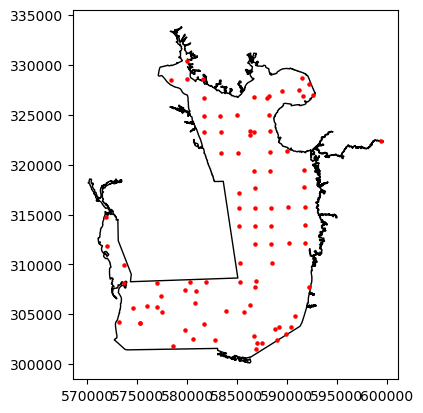

In [159]:
fig, ax = plt.subplots()
extentShp.plot(ax = ax, color='white', edgecolor='black')
gdfWetShp.plot(ax = ax, marker='o', color='red', markersize=5)

## 8.1 Ordinary Kriging: Total Nitrogen <a class="anchor" id="tn_kriging"></a>

This is Ordinary Kriging interpolation method


C:\arcpyenv\arcpygeo\lib\site-packages\matplotlib\image.py:487: RuntimeWarning: overflow encountered in true_divide
  A_scaled /= ((a_max - a_min) / frac)
C:\arcpyenv\arcpygeo\lib\site-packages\matplotlib\image.py:487: RuntimeWarning: overflow encountered in true_divide
  A_scaled /= ((a_max - a_min) / frac)


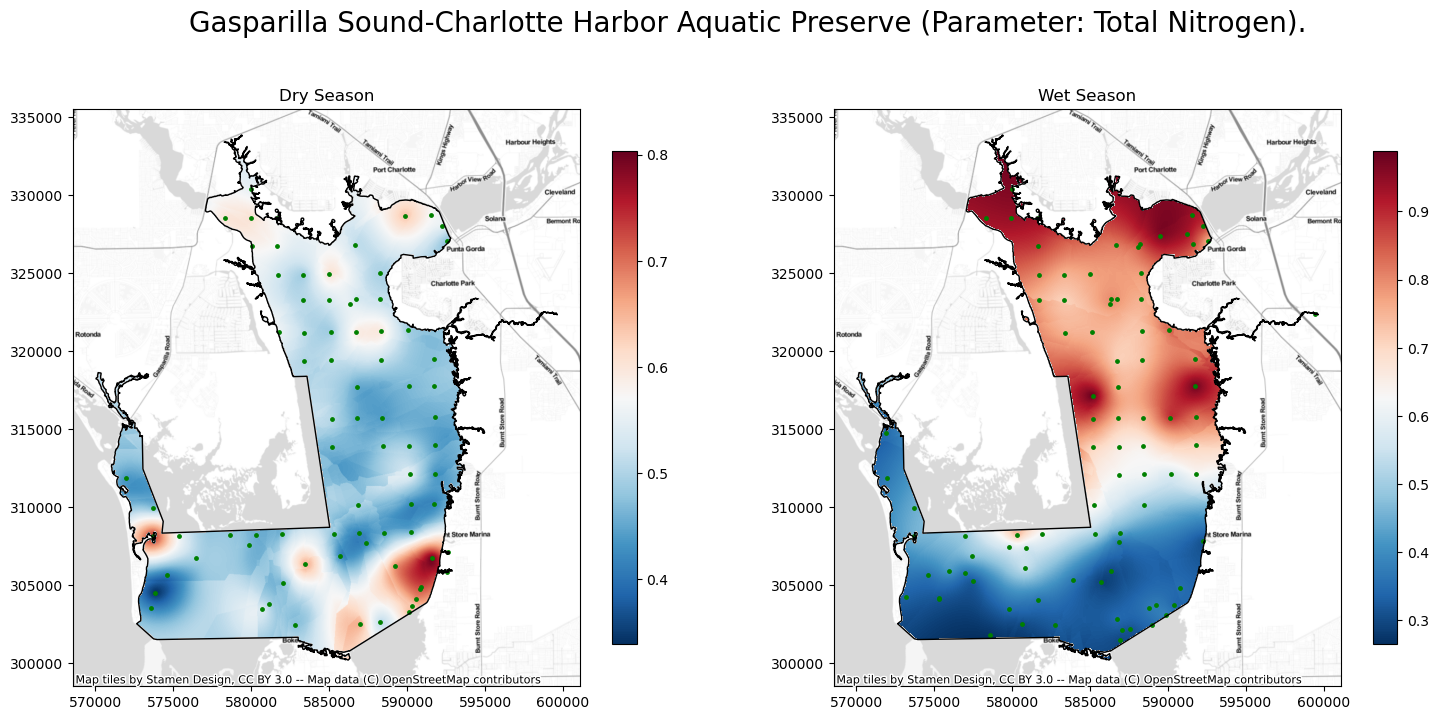

In [176]:
year, season, method, value_field, mask = '2014', 'Dry','ok','ResultValu', gis_path+ '{}.shp'.format(b_name)
in_features = gis_path + season + year+Para_ab+'.shp'
out_ga_layer = gis_path +"{}{}{}.lyrx".format(Para_ab, season.lower(), method.upper())
out_raster = gis_path +"{}{}{}.tif".format(Para_ab, season.lower(),method.upper())

dryOK_2014, dryOKStat = misc.interpolation.interpolation(method = method, input_point = in_features, 
                      out_raster = out_raster, z_field = value_field, 
                      out_ga_layer = out_ga_layer, extent = extent, 
                      mask = mask)

season = 'Wet'
wetOK_2014,wetOKStat = misc.interpolation.interpolation(method = method, input_point = gis_path + season + year+Para_ab+'.shp', 
                      out_raster = gis_path +"{}{}{}.tif".format(Para_ab, season.lower(),method.upper()), z_field = 'ResultValu', 
                      out_ga_layer = gis_path +"{}{}{}.lyrx".format(Para_ab, season.lower(), method.upper()), extent = extent, 
                      mask = mask)

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(18, 8))

fig.suptitle("{} (Parameter: {}).".format(Area, Para),fontsize=20)

misc.interpolation.plot_raster(gdfDryShp, extentShp, dryOK_2014, 'Dry Season', axes[0], fig)
misc.interpolation.plot_raster(gdfWetShp, extentShp, wetOK_2014, 'Wet Season', axes[1], fig)

## 8.2 Inverse Distance Weighting: Total Nitrogen <a class="anchor" id="tn_idw"></a>

This is Inverse Distance Weighting interpolation method


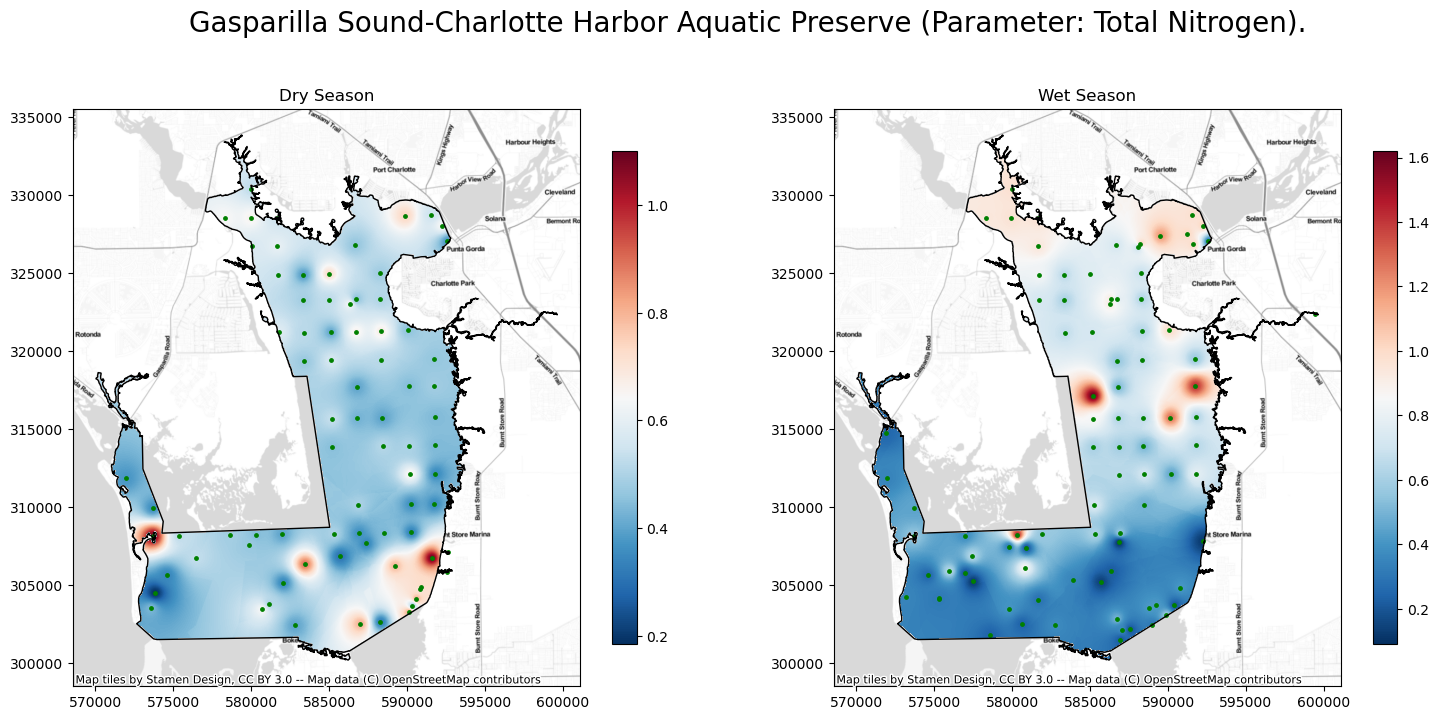

In [177]:
year, season, method, value_field, mask = '2014', 'Dry','idw','ResultValu', gis_path+ '{}.shp'.format(b_name)
in_features = gis_path + season + year+Para_ab+'.shp'
out_ga_layer = gis_path +"{}{}{}.lyrx".format(Para_ab, season.lower(), method.upper())
out_raster = gis_path +"{}{}{}.tif".format(Para_ab, season.lower(),method.upper())

dryIDW_2014 = misc.interpolation.interpolation(method = method, input_point = in_features, 
                      out_raster = out_raster, z_field = value_field, 
                      out_ga_layer = out_ga_layer, extent = extent, 
                      mask = mask)

season = 'Wet'
wetIDW_2014 = misc.interpolation.interpolation(method = method, input_point = gis_path + season + year+Para_ab+'.shp', 
                      out_raster = gis_path +"{}{}{}.tif".format(Para_ab, season.lower(),method.upper()), z_field = 'ResultValu', 
                      out_ga_layer = gis_path +"{}{}{}.lyrx".format(Para_ab, season.lower(), method.upper()), extent = extent, 
                      mask = mask)


In [ ]:
fig, axes = plt.subplots(1,2, figsize=(18, 8))

fig.suptitle("{} (Parameter: {}).".format(Area, Para),fontsize=20)

misc.interpolation.plot_raster(gdfDryShp, extentShp, dryIDW_2014, 'Dry Season', axes[0],fig)
misc.interpolation.plot_raster(gdfWetShp, extentShp, wetIDW_2014, 'Wet Season', axes[1],fig)

## 8.3 Empirical Bayesian Kriging: Total Nitrogen <a class="anchor" id="tn_ebk"></a>

This is Empirical Bayesian Kriging interpolation method
--- Time lapse: 315.51948595046997 seconds ---


C:\arcpyenv\arcpygeo\lib\site-packages\matplotlib\image.py:487: RuntimeWarning: overflow encountered in true_divide
  A_scaled /= ((a_max - a_min) / frac)
C:\arcpyenv\arcpygeo\lib\site-packages\matplotlib\image.py:487: RuntimeWarning: overflow encountered in true_divide
  A_scaled /= ((a_max - a_min) / frac)


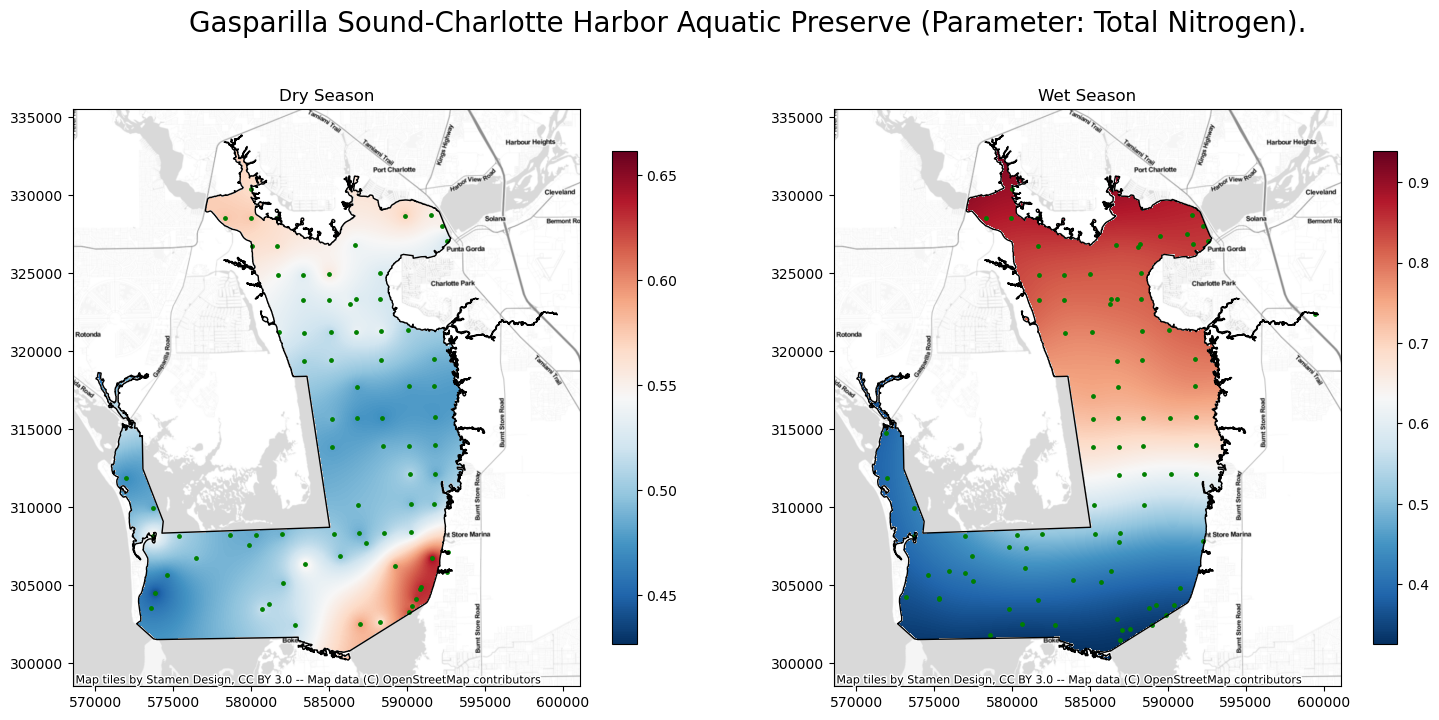

In [182]:
year, season, method, value_field, mask = '2014', 'Dry','ebk','ResultValu', gis_path+ '{}.shp'.format(b_name)
in_features = gis_path + season + year+Para_ab+'.shp'
out_ga_layer = gis_path +"{}{}{}.lyrx".format(Para_ab, season.lower(), method.upper())
out_raster = gis_path +"{}{}{}.tif".format(Para_ab, season.lower(),method.upper())

dryEBK_2014 = misc.interpolation.interpolation(method = method, input_point = in_features, 
                      out_raster = out_raster, z_field = value_field, 
                      out_ga_layer = out_ga_layer, extent = extent, 
                      mask = mask)

season = 'Wet'
wetEBK_2014 = misc.interpolation.interpolation(method = method, input_point = gis_path + season + year+Para_ab+'.shp', 
                      out_raster = gis_path +"{}{}{}.tif".format(Para_ab, season.lower(),method.upper()), z_field = 'ResultValu', 
                      out_ga_layer = gis_path +"{}{}{}.lyrx".format(Para_ab, season.lower(), method.upper()), extent = extent, 
                      mask = mask)

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(18, 8))

fig.suptitle("{} (Parameter: {}).".format(Area, Para),fontsize=20)

misc.interpolation.plot_raster(gdfDryShp, extentShp, dryEBK_2014, 'Dry Season', axes[0],fig)
misc.interpolation.plot_raster(gdfWetShp, extentShp, wetEBK_2014, 'Wet Season', axes[1],fig)

## 8.4 Ordinary Kriging: Total Nitrogen <a class="anchor" id="tn_rk"></a>

This is Regression Kriging interpolation method
--- Time lapse: 416.2434651851654 seconds ---


C:\arcpyenv\arcpygeo\lib\site-packages\matplotlib\image.py:487: RuntimeWarning: overflow encountered in true_divide
  A_scaled /= ((a_max - a_min) / frac)
C:\arcpyenv\arcpygeo\lib\site-packages\matplotlib\image.py:487: RuntimeWarning: overflow encountered in true_divide
  A_scaled /= ((a_max - a_min) / frac)


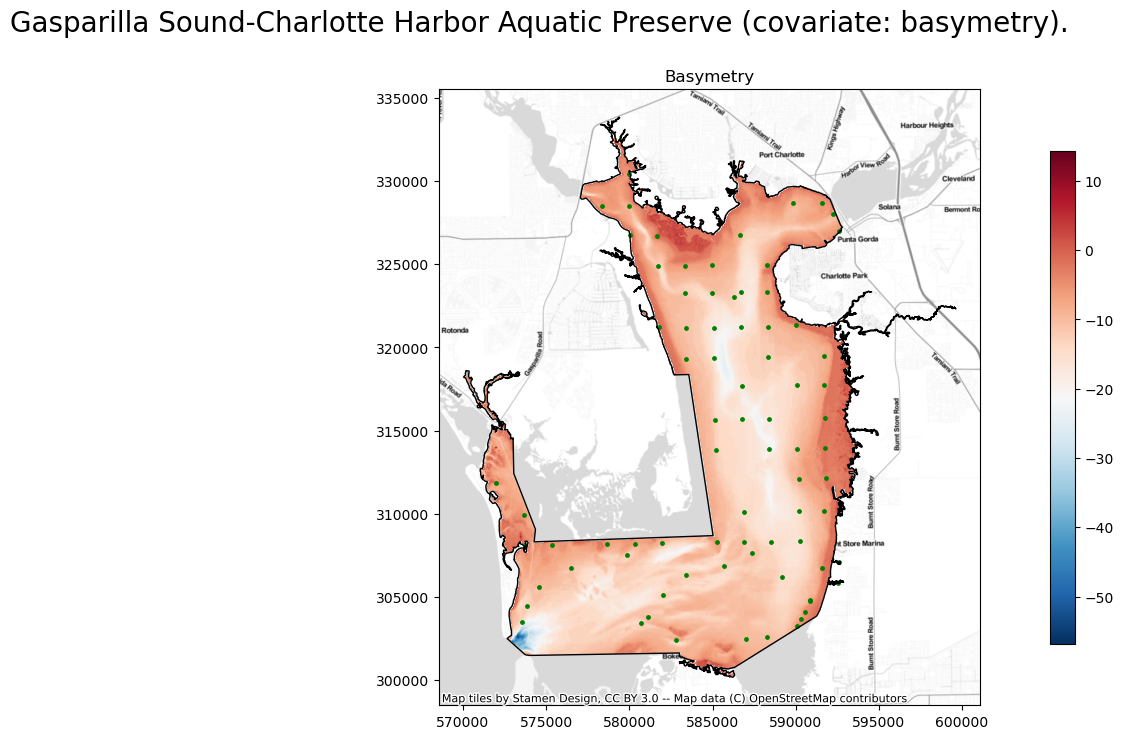

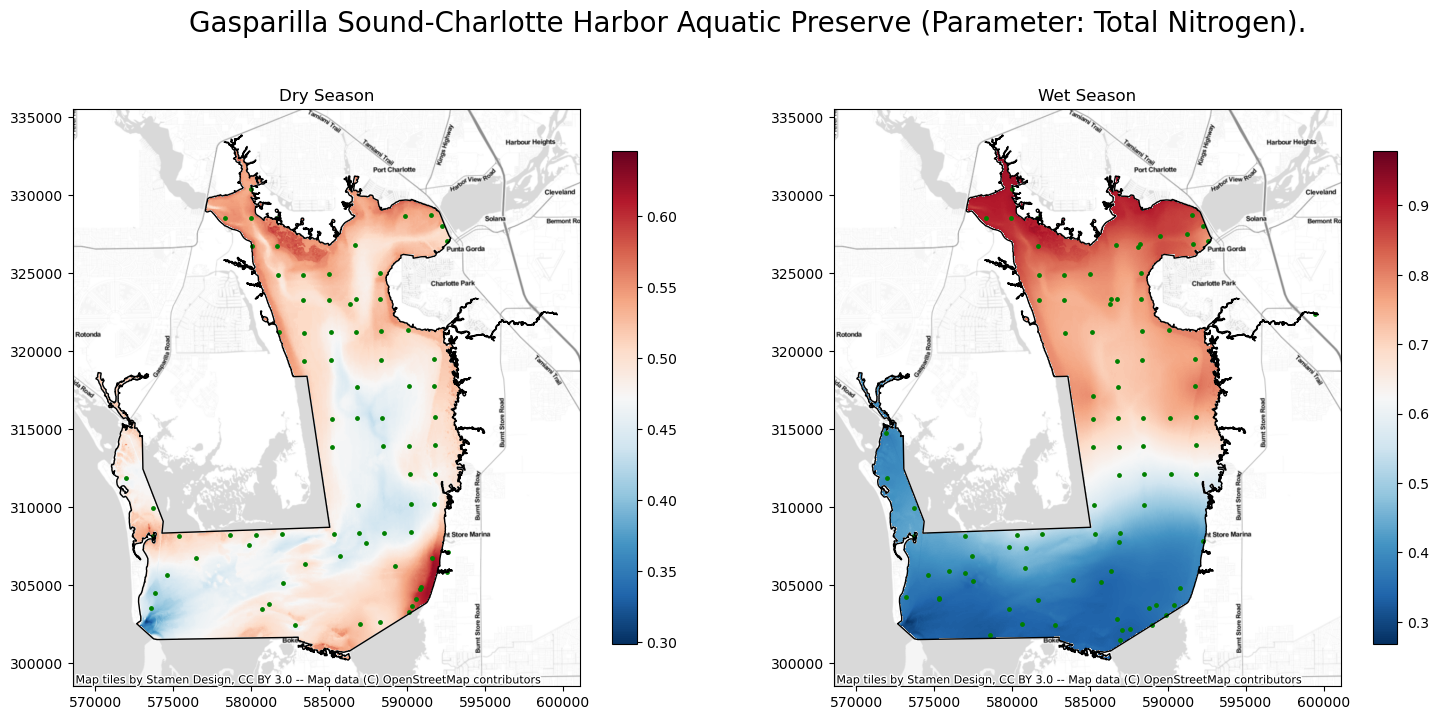

In [183]:
ma_table = pd.read_csv(gis_path + "MA_table.csv")
ra_fname = 'basy_{}.tif'.format(ma_table[ma_table['LONG_NAME']== Area]['MA_AreaID'].iloc[0].astype(str))
fig, ax = plt.subplots(1, figsize=(18, 8))

fig.suptitle("{} (covariate: {}).".format(Area, 'basymetry'),fontsize=20)

gdfDryShp.plot(ax = ax, marker = 'o', color = 'green', markersize = 6)
extentShp.plot(ax = ax, color='none', edgecolor='black')
cx.add_basemap(ax = ax,source=cx.providers.Stamen.TonerLite,crs=gdfDryShp.crs)

#       Raster must added after basemap
with rasterio.open(gis_path + "covariates/basymetry/basy_18.tif", "r+") as covar:
    band = covar.read(1)
    #band = numpy.ma.masked_array(band, mask=(band < -1000))
    #band = numpy.ma.masked_array(band, mask=(band > 1000))
    band = np.ma.masked_where((band < -100) | (band > 100), band)
    retted = rio_pl.show(band, transform=covar.transform, ax = ax, cmap="RdBu_r")
    ax.set_title('Bathymetry')
    # Add legend
    im = retted.get_images()[1]
    fig.colorbar(im, ax=ax,shrink=0.8)

In [ ]:
year, season, method, value_field, mask = '2014', 'Dry','rk','ResultValu', gis_path+ '{}.shp'.format(b_name)
in_features = gis_path + season + year+Para_ab+'.shp'
out_ga_layer = gis_path +"{}{}{}.lyrx".format(Para_ab, season.lower(), method.upper())
out_raster = gis_path +"{}{}{}.tif".format(Para_ab, season.lower(),method.upper())

dryRK_2014 = misc.interpolation.interpolation(method = method, input_point = in_features, 
                      out_raster = out_raster, z_field = value_field, 
                      out_ga_layer = out_ga_layer, extent = extent, 
                      mask = mask, in_explanatory_rasters = gis_path + "covariates/{}".format('NCEI_DEM_30m.tif'))

season = 'Wet'
wetRK_2014 = misc.interpolation.interpolation(method = method, input_point = gis_path + season + year+Para_ab+'.shp', 
                      out_raster = gis_path +"{}{}{}.tif".format(Para_ab, season.lower(),method.upper()), z_field = 'ResultValu', 
                      out_ga_layer = gis_path +"{}{}{}.lyrx".format(Para_ab, season.lower(), method.upper()), extent = extent, 
                      mask = mask, in_explanatory_rasters = gis_path + "covariates/{}".format('NCEI_DEM_30m.tif'))

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(18, 8))

fig.suptitle("{} (Parameter: {}).".format(Area, Para),fontsize=20)

misc.interpolation.plot_raster(gdfDryShp, extentShp, dryRK_2014, 'Dry Season', axes[0],fig)
misc.interpolation.plot_raster(gdfWetShp, extentShp, wetRK_2014, 'Wet Season', axes[1],fig)

# 9. Validation of Interpolation: Total Nitrogen <a class="anchor" id="tn_validation"></a>
## 9.1. Validation of Ordinary Kriging: Total Nitrogen <a class="anchor" id="tn_val_ok"></a>


In [ ]:
gp = arcgisscripting.create()
gp.workspace = gis_path
gp.CheckOutExtension( 'GeoStats' )

ordinarykriging_xml = gis_path+'Kriging.xml'
geo_datasets = arcpy.GeostatisticalDatasets(ordinarykriging_xml)
geo_datasets.dataset1 = gis_path+"Dry"+year+Para_ab+'.shp'
geo_datasets.dataset1Field = 'ResultValu'
arcpy.GACreateGeostatisticalLayer_ga(ordinarykriging_xml, geo_datasets, Para_ab+'dryok_GA')
arcpy.SaveToLayerFile_management(Para_ab+'dryok_GA', gis_path+Para_ab+'dryok_GA.lyrx',
                                 'ABSOLUTE')

ordinarykriging_xml = gis_path+'Kriging.xml'
geo_datasets = arcpy.GeostatisticalDatasets(ordinarykriging_xml)
geo_datasets.dataset1 = gis_path+"Wet"+year+Para_ab+'.shp'
geo_datasets.dataset1Field = 'ResultValu'
arcpy.GACreateGeostatisticalLayer_ga(ordinarykriging_xml, geo_datasets, Para_ab+'wetok_GA')
arcpy.SaveToLayerFile_management(Para_ab+'wetok_GA', gis_path+Para_ab+'wetok_GA.lyrx',
                                 'ABSOLUTE')

In [186]:
inLayer = gis_path +Para_ab+ "dryok_GA.lyrx"
cvResult = arcpy.CrossValidation_ga(inLayer)
dryOKStat = pd.DataFrame(
            {
              "meanError": round(float(cvResult.meanError),4),
              "meanStandardizedError": round(float(cvResult.meanStandardized),4),
              "rootMeanSquareError": round(float(cvResult.rootMeanSquare),4)
                                          },index=["Ordinary Kriging"])


inLayer = gis_path +Para_ab+ "wetok_GA.lyrx"
cvResult = arcpy.CrossValidation_ga(inLayer)
wetOKStat = pd.DataFrame(
            {
              "meanError": round(float(cvResult.meanError),4),
              "meanStandardizedError": round(float(cvResult.meanStandardized),4),
              "rootMeanSquareError": round(float(cvResult.rootMeanSquare),4)
                                          },index=["Ordinary Kriging"])

In [187]:
print("Interpolation assessment of Ordinary Kriging in dry season data")
display(dryOKStat)
print("Interpolation assessment of Ordinary Kriging in wet season data")
display(wetOKStat)

Interpolation assessment of Ordinary Kriging in dry season data


meanError  meanStandardizedError  rootMeanSquareError
Ordinary Kriging     0.0025                 0.0152               0.1709

Interpolation assessment of Ordinary Kriging in wet season data


meanError  meanStandardizedError  rootMeanSquareError
Ordinary Kriging    -0.0087                 -0.055               0.2596

In [188]:
arcpy.SaveToLayerFile_management(gis_path+Para_ab + "dryIDW.lyrx", gis_path+Para_ab+'dryIDW_GA.lyrx',
                                 'ABSOLUTE')
arcpy.SaveToLayerFile_management(gis_path+Para_ab + "wetIDW.lyrx", gis_path+Para_ab+'wetIDW_GA.lyrx',
                                 'ABSOLUTE')

<Result 'D:\\Water_Quailty\\Test02200\\TNwetIDW_GA.lyrx'>

## 9.2. Validation of IDW: Total Nitrogen <a class="anchor" id="tn_val_idw"></a>


In [189]:
inLayer = gis_path+Para_ab + "dryIDW_GA.lyrx"
cvResult = arcpy.CrossValidation_ga(inLayer)
dryIDWStat = pd.DataFrame(
            {
              "meanError": round(float(cvResult.meanError),4),
#               "meanStandardizedError": round(float(cvResult.meanStandardized),4),
              "meanStandardizedError": "Nan",
              "rootMeanSquareError": round(float(cvResult.rootMeanSquare),4)
                                          },index=["Inverse Distance Weighting"])


inLayer = gis_path+Para_ab + "wetIDW_GA.lyrx"
cvResult = arcpy.CrossValidation_ga(inLayer)
wetIDWStat = pd.DataFrame(
            {
              "meanError": round(float(cvResult.meanError),4),
#               "meanStandardizedError": round(float(cvResult.meanStandardized),4),
              "meanStandardizedError": "Nan",
              "rootMeanSquareError": round(float(cvResult.rootMeanSquare),4)
                                          },index=["Inverse Distance Weighting"])

In [190]:
cvResult.meanStandardized

'NaN'

In [191]:
print("Interpolation assessment of Inverse Distance Weighting in dry season data")
display(dryIDWStat)
print("Interpolation assessment of Inverse Distance Weighting in wet season data")
display(wetIDWStat)

Interpolation assessment of Inverse Distance Weighting in dry season data


meanError meanStandardizedError  \
Inverse Distance Weighting     0.0012                   Nan   

                            rootMeanSquareError  
Inverse Distance Weighting               0.1715

Interpolation assessment of Inverse Distance Weighting in wet season data


meanError meanStandardizedError  \
Inverse Distance Weighting     0.0018                   Nan   

                            rootMeanSquareError  
Inverse Distance Weighting               0.2691

In [192]:
arcpy.SaveToLayerFile_management(gis_path+Para_ab+"EBK_Dry_Layer", gis_path+Para_ab+'dryEBK_GA.lyrx',
                                 'ABSOLUTE')
arcpy.SaveToLayerFile_management(gis_path+Para_ab+"EBK_Wet_Layer", gis_path+Para_ab+'wetEBK_GA.lyrx',
                                 'ABSOLUTE')

<Result 'D:\\Water_Quailty\\Test02200\\TNwetEBK_GA.lyrx'>

## 9.3. Validation of Empirical Bayesian Kriging: Total Nitrogen <a class="anchor" id="tn_val_ebk"></a>


In [193]:
inLayer = gis_path+Para_ab + "dryEBK_GA.lyrx"
cvResult = arcpy.CrossValidation_ga(inLayer)
dryEBKStat = pd.DataFrame(
            {
              "meanError": round(float(cvResult.meanError),4),
              "meanStandardizedError": round(float(cvResult.meanStandardized),4),
              "rootMeanSquareError": round(float(cvResult.rootMeanSquare),4)
                                          },index=["Empirical Bayesian Kriging"])


inLayer = gis_path+Para_ab + "wetEBK_GA.lyrx"
cvResult = arcpy.CrossValidation_ga(inLayer)
wetEBKStat = pd.DataFrame(
            {
              "meanError": round(float(cvResult.meanError),4),
              "meanStandardizedError": round(float(cvResult.meanStandardized),4),
              "rootMeanSquareError": round(float(cvResult.rootMeanSquare),4)
                                          },index=["Empirical Bayesian Kriging"])

In [194]:
print("Interpolation assessment of Empirical Bayesian Kriging in dry season data")
display(dryEBKStat)
print("Interpolation assessment of Empirical Bayesian Kriging in wet season data")
display(wetEBKStat)

Interpolation assessment of Empirical Bayesian Kriging in dry season data


meanError  meanStandardizedError  \
Empirical Bayesian Kriging    -0.0022                 -0.014   

                            rootMeanSquareError  
Empirical Bayesian Kriging               0.1625

Interpolation assessment of Empirical Bayesian Kriging in wet season data


meanError  meanStandardizedError  \
Empirical Bayesian Kriging    -0.0028                -0.0121   

                            rootMeanSquareError  
Empirical Bayesian Kriging               0.2437

In [195]:
arcpy.SaveToLayerFile_management(gis_path+Para_ab+"dryRK_GA", gis_path+Para_ab+'dryRK_GA.lyrx',
                                 'ABSOLUTE')
arcpy.SaveToLayerFile_management(gis_path+Para_ab+"wetRK_GA", gis_path+Para_ab+'wetRK_GA.lyrx',
                                 'ABSOLUTE')

<Result 'D:\\Water_Quailty\\Test02200\\TNwetRK_GA.lyrx'>

## 9.4. Validation of Regression Kriging: Total Nitrogen <a class="anchor" id="tn_val_rk"></a>

In [196]:
inLayer = gis_path+Para_ab + "dryRK_GA.lyrx"
cvResult = arcpy.CrossValidation_ga(inLayer)
dryRKStat = pd.DataFrame(
            {
              "meanError": round(float(cvResult.meanError),4),
              "meanStandardizedError": round(float(cvResult.meanStandardized),4),
              "rootMeanSquareError": round(float(cvResult.rootMeanSquare),4)
                                          },index=["Regression Kriging"])


inLayer = gis_path+Para_ab + "wetRK_GA.lyrx"
cvResult = arcpy.CrossValidation_ga(inLayer)
wetRKStat = pd.DataFrame(
            {
              "meanError": round(float(cvResult.meanError),4),
              "meanStandardizedError": round(float(cvResult.meanStandardized),4),
              "rootMeanSquareError": round(float(cvResult.rootMeanSquare),4)
                                          },index=["Regression Kriging"])

In [197]:
print("Interpolation assessment of Regression Kriging in dry season data")
display(dryRKStat)
print("Interpolation assessment of Regression Kriging in wet season data")
display(wetRKStat)

Interpolation assessment of Regression Kriging in dry season data


meanError  meanStandardizedError  rootMeanSquareError
Regression Kriging      0.002                 0.0046               0.1594

Interpolation assessment of Regression Kriging in wet season data


meanError  meanStandardizedError  rootMeanSquareError
Regression Kriging     0.0084                 0.0139               0.2506

# 10. Validation Summary: All three variables <a class="anchor" id="val_sum"></a>

In [198]:
sumStat1   = pd.concat([dryOKStat,dryIDWStat])
sumStat2   = pd.concat([dryEBKStat,dryRKStat])
sumStatDry3 = pd.concat([sumStat1,sumStat2])

In [205]:
print("Summary of interpolation assessment of TN in dry season data")
sumStatDry3

Summary of interpolation assessment of TN in dry season data


meanError meanStandardizedError  \
Ordinary Kriging               0.0025                0.0152   
Inverse Distance Weighting     0.0012                   Nan   
Empirical Bayesian Kriging    -0.0022                -0.014   
Regression Kriging             0.0020                0.0046   

                            rootMeanSquareError  
Ordinary Kriging                         0.1709  
Inverse Distance Weighting               0.1715  
Empirical Bayesian Kriging               0.1625  
Regression Kriging                       0.1594

In [200]:
sumStat3   = pd.concat([wetOKStat,wetIDWStat])
sumStat4   = pd.concat([wetEBKStat,wetRKStat])
sumStatWet3 = pd.concat([sumStat3,sumStat4])

In [204]:
print("Summary of interpolation assessment of TN in wet season data")
sumStatWet3

Summary of interpolation assessment of TN in wet season data


meanError meanStandardizedError  \
Ordinary Kriging              -0.0087                -0.055   
Inverse Distance Weighting     0.0018                   Nan   
Empirical Bayesian Kriging    -0.0028               -0.0121   
Regression Kriging             0.0084                0.0139   

                            rootMeanSquareError  
Ordinary Kriging                         0.2596  
Inverse Distance Weighting               0.2691  
Empirical Bayesian Kriging               0.2437  
Regression Kriging                       0.2506

In [207]:
print("Summary of interpolation assessment of DO in wet season data")
sumStatDry

Summary of interpolation assessment of DO in wet season data


meanError meanStandardizedError  \
Ordinary Kriging               0.0559                0.0328   
Inverse Distance Weighting    -0.0690                   Nan   
Empirical Bayesian Kriging    -0.0076               -0.0013   
Regression Kriging             0.0189                0.0129   

                            rootMeanSquareError  
Ordinary Kriging                         1.6362  
Inverse Distance Weighting               1.7750  
Empirical Bayesian Kriging               1.5951  
Regression Kriging                       1.5990

In [206]:
print("Summary of interpolation assessment of DO in wet season data")
sumStatWet

Summary of interpolation assessment of DO in wet season data


meanError meanStandardizedError  \
Ordinary Kriging               0.0121                0.0083   
Inverse Distance Weighting    -0.0490                   Nan   
Empirical Bayesian Kriging    -0.0079               -0.0036   
Regression Kriging             0.0466                0.0254   

                            rootMeanSquareError  
Ordinary Kriging                         1.8292  
Inverse Distance Weighting               1.9753  
Empirical Bayesian Kriging               1.7716  
Regression Kriging                       1.7467

In [208]:
print("Summary of interpolation assessment of Salinity in wet season data")
sumStatDry2

Summary of interpolation assessment of Salinity in wet season data


meanError meanStandardizedError  \
Ordinary Kriging               0.0438                0.0154   
Inverse Distance Weighting    -0.1179                   Nan   
Empirical Bayesian Kriging    -0.0239               -0.0105   
Regression Kriging            -0.0325               -0.0207   

                            rootMeanSquareError  
Ordinary Kriging                         2.6206  
Inverse Distance Weighting               2.9739  
Empirical Bayesian Kriging               2.5483  
Regression Kriging                       2.5417

In [209]:
print("Summary of interpolation assessment of Salinity in wet season data")
sumStatWet2

Summary of interpolation assessment of Salinity in wet season data


meanError meanStandardizedError  \
Ordinary Kriging               0.1518                0.0535   
Inverse Distance Weighting    -0.1302                   Nan   
Empirical Bayesian Kriging    -0.0376               -0.0041   
Regression Kriging             0.0006               -0.0076   

                            rootMeanSquareError  
Ordinary Kriging                         9.0413  
Inverse Distance Weighting              10.3147  
Empirical Bayesian Kriging               8.9271  
Regression Kriging                       8.9768